# **PREPARACION**

# **1. Importación de *modules***

In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# **2. Importación del dataset *properatti.csv***

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#data_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ProyectosDHDS-main/data/properatti.csv", sep = ",", low_memory=False)
data_raw = pd.read_csv("../data/properatti.csv", sep = ",", low_memory=False) 
#data.head(3)
data_raw.shape

(121220, 26)

# **3. Tratamiento de los datos**

## 3.1. Selección del subdataset AMBA

In [4]:
amba = ['Capital Federal', 'Bs.As. G.B.A. Zona Sur', 'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Oeste']
data_amba = data_raw[data_raw["state_name"].isin(amba)]
data_amba.shape

(81150, 26)

## **3.2. Limpieza e imputaciones**

### 3.2.1. Dropeo de columnas no informativas

In [5]:
cols2keep = ['property_type', 'state_name', 'place_name','place_with_parent_names','surface_total_in_m2','surface_covered_in_m2','price_usd_per_m2', 'rooms', 'description', 'title', 'properati_url']
data_col_clean = data_amba.loc[:, cols2keep]
data_col_clean.columns
data_col_clean.shape

Index(['property_type', 'state_name', 'place_name', 'place_with_parent_names',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'rooms', 'description', 'title', 'properati_url'],
      dtype='object')

(81150, 11)

### 3.2.2. Chequeo de valores nulos (no modifica datasets)

In [6]:
cant_nulos_por_campo = data_col_clean.apply(lambda x: x.isnull().sum(), axis = 0)
percent_nulos_por_campo = data_col_clean.apply(lambda x: (100 * x.isnull().sum() / data_col_clean.shape[0]).round(2), axis = 0)
pd.DataFrame({'null': cant_nulos_por_campo, '%': percent_nulos_por_campo,'type': data_col_clean.dtypes})

,null,%,type
property_type,0,0.00,object
state_name,0,0.00,object
place_name,23,0.03,object
place_with_parent_names,0,0.00,object
surface_total_in_m2,22792,28.09,float64
surface_covered_in_m2,8505,10.48,float64
price_usd_per_m2,29515,36.37,float64
rooms,51211,63.11,float64
description,1,0.00,object
title,0,0.00,object


### 3.2.3. Imputación de la columna *rooms*


In [7]:
# Comprobamos el tipo y los valores (no modifica datasets)
print(f'''summary rooms

type: {data_col_clean.rooms.dtype}
N total: {data_col_clean.shape[0]}
N null: {data_col_clean.rooms.isnull().sum()}
% null: {round((data_col_clean.rooms.isnull().sum() / data_col_clean.shape[0] * 100), 2)}%
unique: {np.sort(data_col_clean['rooms'].unique())}''')

summary rooms

type: float64
N total: 81150
N null: 51211
% null: 63.11%
unique: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 22. 25. 32. nan]


In [8]:
# Uniformamos la capitalización de las variables que se van a usar para imputar rooms
data_col_clean['title'] = data_col_clean.title.str.upper()
data_col_clean['description'] = data_col_clean.description.str.upper()

In [9]:
room_mapper = {"UNO": "1", "UN": "1", "DOS": "2", "TRES": "3", "CUATRO": "4", "CINCO": "5", "SEIS": "6", "SIETE": "7", "OCHO": "8",
             "NUEVE": "9", "DIEZ": "10", "MONO AMBIENTE": "1 AMBIENTE", "MONOAMBIENTE": "1 AMBIENTE", "MONOAMB" : "1 AMBIENTE", "AMBIENTE DIVISIBLE": "1 AMBIENTE",
             "DORMITORIOS": "AMBIENTE", "DORMITORIO": "AMBIENTE", "HABITACIONES": "AMBIENTE", "HABITACION": "AMBIENTE"}

for key in room_mapper.keys():
    data_col_clean.description = data_col_clean.description.str.replace(key, room_mapper[key], regex = False)
    data_col_clean.title = data_col_clean.title.str.replace(key, room_mapper[key], regex = False)

In [10]:
data_input = data_col_clean

array_regex = ["(\d+)AMB", "(\d+) AMB"]

for regex in array_regex:
    controlRooms = data_input[(data_input.rooms.isnull())]
    controlRooms.rooms = controlRooms.title.str.extract(regex).astype(float)
    data_input.update(controlRooms)
    controlRooms = data_input[(data_input.rooms.isnull())]
    controlRooms.rooms = controlRooms.description.str.extract(regex).astype(float)
    data_input.update(controlRooms)

array_regex = ["(\d+)DORM", "(\d+) DORM", "(\d+)HABITACIO", "(\d+) HABITACIO"]

for regex in array_regex:
    controlRooms = data_input[(data_input.rooms.isnull())]
    controlRooms.rooms = controlRooms.title.str.extract(regex).astype(float) - 1
    data_input.update(controlRooms)
    controlRooms = data_input[(data_input.rooms.isnull())]
    controlRooms.rooms = controlRooms.description.str.extract(regex).astype(float) - 1
    data_input.update(controlRooms)

C:\Users\maela\anaconda3\envs\dhdsblend2021\lib\site-packages\pandas\core\generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [11]:
# Comprobamos el tipo y los valores luego de la imputación (no modifica datasets)
print(f'''summary rooms

type: {data_input['rooms'].dtype}
N total: {data_input.shape[0]}
N null: {data_input['rooms'].isnull().sum()}
% null: {round((data_input['rooms'].isnull().sum() / data_col_clean.shape[0] * 100), 2)}%
unique: {np.sort(data_input['rooms'].unique())}''')

summary rooms

type: float64
N total: 81150
N null: 10685
% null: 13.17%
unique: [0.0000e+00 1.0000e+00 2.0000e+00 3.0000e+00 4.0000e+00 5.0000e+00
 6.0000e+00 7.0000e+00 8.0000e+00 9.0000e+00 1.0000e+01 1.1000e+01
 1.2000e+01 1.3000e+01 1.4000e+01 1.5000e+01 1.6000e+01 1.7000e+01
 1.8000e+01 2.0000e+01 2.1000e+01 2.2000e+01 2.3000e+01 2.4000e+01
 2.5000e+01 2.7000e+01 2.9000e+01 3.0000e+01 3.2000e+01 3.3000e+01
 3.5000e+01 3.6000e+01 3.7000e+01 4.0000e+01 4.2000e+01 4.5000e+01
 4.7000e+01 5.0000e+01 5.1000e+01 5.2000e+01 5.4000e+01 6.0000e+01
 6.2000e+01 7.0000e+01 7.2000e+01 8.0000e+01 8.2000e+01 8.3000e+01
 8.5000e+01 8.7000e+01 9.0000e+01 9.1000e+01 1.0000e+02 1.0300e+02
 1.2500e+02 2.1000e+02 2.7200e+02 4.0300e+02 6.0200e+02 6.6200e+02
 7.7200e+02 8.3100e+02 9.0200e+02 2.0000e+03 4.0000e+03 6.0030e+03
 2.0173e+04 2.0174e+04 6.5003e+04 1.1200e+05        nan]


### 3.2.4. Dropeo de duplicados

In [12]:
data_input.drop_duplicates(keep = "first", inplace = True)

### 3.2.5. Limpieza de *outliers* en *price_usd_per_m2*

In [13]:
#búsqueda y reemplazo de outliers (de más de 2 std, 95%) por NaN en las columnas numéricas, en un solo paso
data_out = data_input
df_sub = data_out.loc[:, 'price_usd_per_m2']
lim = np.abs((df_sub - df_sub.mean()) / df_sub.std(ddof=0)) < 2
data_out.loc[:, 'price_usd_per_m2'] = df_sub.where(lim, np.nan)
data_out.shape

(81150, 11)

### 3.2.6. Limpieza de *outliers* en *rooms*, *surface_covered* y *surface_total*

In [14]:
data_out = data_out.loc[(data_out['rooms'] <= 10) & (data_out['surface_covered_in_m2'] <= 700) & (data_out['surface_total_in_m2'] <= 1000)]
data_out.shape

(47174, 11)

### 3.2.7. Dropeo de *NaNs*

In [15]:
data_na = data_out
data_na.dropna(axis = 0, how = 'any', subset = ['property_type', 'state_name', 'place_name', 'surface_total_in_m2','surface_covered_in_m2', 'rooms', 'price_usd_per_m2'], inplace = True)
data_na.shape

C:\Users\maela\AppData\Local\Temp/ipykernel_9724/51777832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_na.dropna(axis = 0, how = 'any', subset = ['property_type', 'state_name', 'place_name', 'surface_total_in_m2','surface_covered_in_m2', 'rooms', 'price_usd_per_m2'], inplace = True)


(41760, 11)

In [16]:
# Último chequeo de que no hay nans en las columnas de trabajo (feature y targets)

cant_nulos_por_campo = data_na.apply(lambda x: x.isnull().sum(), axis = 0)
percent_nulos_por_campo = data_na.apply(lambda x: (100 * x.isnull().sum() / data_na.shape[0]).round(2), axis = 0)
pd.DataFrame({'null': cant_nulos_por_campo, '%': percent_nulos_por_campo,'type': data_na.dtypes})

,null,%,type
property_type,0,0.0,object
state_name,0,0.0,object
place_name,0,0.0,object
place_with_parent_names,0,0.0,object
surface_total_in_m2,0,0.0,float64
surface_covered_in_m2,0,0.0,float64
price_usd_per_m2,0,0.0,float64
rooms,0,0.0,float64
description,0,0.0,object
title,0,0.0,object


### 3.2.8. Ploteo de correlación entre variables

<AxesSubplot:>

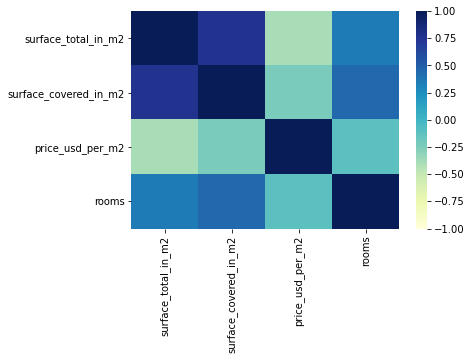

In [17]:
sns.heatmap(data_na.corr(), vmin=-1, vmax=1, center=0, cmap="YlGnBu")

## **3.3. Creacion de columnas *dummies***

### 3.3.1. *Amenities*

In [18]:
#fracciono la columna properti_url para sacar la nube de palabras mas repetidas
patron_url = re.compile(pattern = "_", flags = re.IGNORECASE)
lista_url = data_na["properati_url"].apply(lambda x : patron_url.split(x))
serie_palabras = pd.Series(np.hstack(lista_url))
#serie_palabras.value_counts().head(20).plot(kind="bar")
serie_palabras.value_counts().head(50)

venta                       41707
departamento                27273
garage                      21321
lavadero                    19150
balcon                      17077
parrilla                    15963
luminoso                    13776
piscina                     13440
suite                       12475
casa                        11905
toilette                    11485
placard                     10813
terraza                     10564
vestidor                     8436
jardin                       7475
patio                        6466
dependencias                 6031
sum                          5935
aire-acondicionado           5553
baulera                      5432
amenities                    5415
gimnasio                     4698
estrenar                     4368
lujoso                       4235
vista                        3670
subte-linea-d                3620
quincho                      3286
hidromasaje                  2981
subte-linea-b                2975
subte-linea-a 

In [19]:
# a partir de la nube de palabras selecciono las que son buenos adicionales
adicionales = ["garage", "balcon", "parrilla", "piscina", "terraza", "patio", "jardin", "quincho", "sum", "amenities", "baulera", "gimnasio", "subte-linea-d", "subte-linea-b", "subte-linea-a", "subte-linea-h", "subte-linea-e"]

In [20]:
#elimino el primer elemento de lista_url para no tener el elemento con el http: etc
for sublist in lista_url:
  del sublist[0]

lista_url

0         [venta, ph, mataderos, lavadero, patio, inmobi...
2         [venta, departamentos, mataderos, lavadero, pl...
6         [venta, ph, munro, lavadero, patio, garage, al...
7         [venta, departamentos, belgrano, lavadero, pis...
8         [venta, departamentos, belgrano, lavadero, pis...
                                ...                        
121154    [venta, casa, la-plata, suite, parrilla, pisci...
121158    [venta, departamento, recoleta, pueyrredon-av-...
121215    [venta, departamento, belgrano, balcon, suite,...
121216    [venta, casa, beccar, suite, hidromasaje, jard...
121217    [venta, departamento, villa-urquiza, holmberg,...
Name: properati_url, Length: 41760, dtype: object

In [21]:
#creo una función que compare la lista de palabras con la lista de listas
#y me da como resultado una lista de listas de palabras true/false segun coincida o no 
def buscador_palabras(quebuscar, dondebuscar):
  listadeextras = []
  for listas in dondebuscar:
    extras = []
    for palabra in quebuscar:
      if palabra in listas:
        extras.append(1)
      else:
        extras.append(0)
    listadeextras.append(extras)
  #print(listadeextras)
  return listadeextras     

In [22]:
#aplico la funcion a mi lista "adicionales" y "lista_url"
#chequeo que tenga la misma longitud de data
resultado = buscador_palabras(adicionales, lista_url)
len(resultado)

41760

In [23]:
#convierto resultado en dataframe, y renombro las columnas por la lista de palabras adicionales
df = pd.DataFrame(resultado)
df.columns = ["garage", "balcon", "parrilla", "piscina", "terraza", "patio", "jardin", "quincho", "s.u.m.", "amenities", "baulera", "gimnasio","subte-linea-d", "subte-linea-b", "subte-linea-a", "subte-linea-h", "subte-linea-e"]
df = df.add_prefix('am_')
df

,am_garage,am_balcon,am_parrilla,am_piscina,am_terraza,am_patio,am_jardin,am_quincho,am_s.u.m.,am_amenities,am_baulera,am_gimnasio,am_subte-linea-d,am_subte-linea-b,am_subte-linea-a,am_subte-linea-h,am_subte-linea-e
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41755,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
41756,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
41757,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
41758,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0


In [24]:
#uno el dataframe original con el nuevo generado de true/false
#data = pd.merge(data,df,left_index=True, right_index=True)
data_dum_1 = data_na.reset_index().join(df)
data_dum_1.columns
#antes me puso los dos indices como resultado del merge, y tuve que sacar la primera columna
#data.drop(columns=data.columns[0], axis=1,inplace=True)
data_dum_1.shape

Index(['index', 'property_type', 'state_name', 'place_name',
       'place_with_parent_names', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'rooms', 'description',
       'title', 'properati_url', 'am_garage', 'am_balcon', 'am_parrilla',
       'am_piscina', 'am_terraza', 'am_patio', 'am_jardin', 'am_quincho',
       'am_s.u.m.', 'am_amenities', 'am_baulera', 'am_gimnasio',
       'am_subte-linea-d', 'am_subte-linea-b', 'am_subte-linea-a',
       'am_subte-linea-h', 'am_subte-linea-e'],
      dtype='object')

(41760, 29)

### 3.3.2. *State name*

In [25]:
df_sn = pd.get_dummies(data_dum_1["state_name"], prefix = 'sn', drop_first = True)

In [26]:
data_dum_2 = data_dum_1.join(df_sn)
data_dum_2.columns
data_dum_2.shape

Index(['index', 'property_type', 'state_name', 'place_name',
       'place_with_parent_names', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'rooms', 'description',
       'title', 'properati_url', 'am_garage', 'am_balcon', 'am_parrilla',
       'am_piscina', 'am_terraza', 'am_patio', 'am_jardin', 'am_quincho',
       'am_s.u.m.', 'am_amenities', 'am_baulera', 'am_gimnasio',
       'am_subte-linea-d', 'am_subte-linea-b', 'am_subte-linea-a',
       'am_subte-linea-h', 'am_subte-linea-e', 'sn_Bs.As. G.B.A. Zona Oeste',
       'sn_Bs.As. G.B.A. Zona Sur', 'sn_Capital Federal'],
      dtype='object')

(41760, 32)

### 3.3.3. *Property type*

In [27]:
df_pt = pd.get_dummies(data_dum_2["property_type"], prefix = 'pt', drop_first = True)

In [28]:
data_dum_3 = data_dum_2.join(df_pt)
data_dum_3.columns
data_dum_3.shape

Index(['index', 'property_type', 'state_name', 'place_name',
       'place_with_parent_names', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'rooms', 'description',
       'title', 'properati_url', 'am_garage', 'am_balcon', 'am_parrilla',
       'am_piscina', 'am_terraza', 'am_patio', 'am_jardin', 'am_quincho',
       'am_s.u.m.', 'am_amenities', 'am_baulera', 'am_gimnasio',
       'am_subte-linea-d', 'am_subte-linea-b', 'am_subte-linea-a',
       'am_subte-linea-h', 'am_subte-linea-e', 'sn_Bs.As. G.B.A. Zona Oeste',
       'sn_Bs.As. G.B.A. Zona Sur', 'sn_Capital Federal', 'pt_apartment',
       'pt_house', 'pt_store'],
      dtype='object')

(41760, 35)

### 3.3.4. *Place name*

In [29]:
df_pn = pd.get_dummies(data_dum_3["place_name"], prefix = "pn", drop_first = True)

In [30]:
data_dum_4 = data_dum_3.join(df_pn)
data_dum_4.columns
data_dum_4.shape

Index(['index', 'property_type', 'state_name', 'place_name',
       'place_with_parent_names', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'rooms', 'description',
       ...
       'pn_Villa de Mayo', 'pn_Villa del Parque',
       'pn_Village Golf & Tennis Country Club', 'pn_Virasoro Village',
       'pn_Virrey del Pino', 'pn_Virreyes', 'pn_Wilde', 'pn_William Morris',
       'pn_Zelaya', 'pn_coordenadas 34.255511'],
      dtype='object', length=475)

(41760, 475)

### 3.3.5. Dropeo de columnas innecesarias

In [31]:
data = data_dum_4.drop(columns = ['index', 'property_type', 'state_name', 'place_name', 'place_with_parent_names', 'description', 'title', 'properati_url'])
bool_mapper = {False: 0, True: 1}
data.replace(bool_mapper, inplace = True)
data.shape
#list(data.columns)
data

(41760, 467)

,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,rooms,am_garage,am_balcon,am_parrilla,am_piscina,am_terraza,am_patio,...,pn_Villa de Mayo,pn_Villa del Parque,pn_Village Golf & Tennis Country Club,pn_Virasoro Village,pn_Virrey del Pino,pn_Virreyes,pn_Wilde,pn_William Morris,pn_Zelaya,pn_coordenadas 34.255511
0,55.0,40.0,1127.272727,2.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,55.0,55.0,1309.090909,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,106.0,78.0,1226.415094,2.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,45.0,40.0,3066.666667,1.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,65.0,60.0,3000.000000,2.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41755,205.0,205.0,1439.024390,3.0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
41756,44.0,39.0,3750.000000,1.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41757,113.0,93.0,7699.115044,3.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
41758,360.0,360.0,1383.333333,3.0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
cant_nulos_por_campo = data.apply(lambda x: x.isnull().sum(), axis = 0)
percent_nulos_por_campo = data.apply(lambda x: (100 * x.isnull().sum() / data_na.shape[0]).round(2), axis = 0)
pd.DataFrame({'null': cant_nulos_por_campo, '%': percent_nulos_por_campo,'type': data.dtypes})

,null,%,type
surface_total_in_m2,0,0.0,float64
surface_covered_in_m2,0,0.0,float64
price_usd_per_m2,0,0.0,float64
rooms,0,0.0,float64
am_garage,0,0.0,int64
...,...,...,...
pn_Virreyes,0,0.0,int64
pn_Wilde,0,0.0,int64
pn_William Morris,0,0.0,int64
pn_Zelaya,0,0.0,int64


# **4. Exportación del dataset resultante a un nuevo *.csv***

In [33]:
# para exportar resultados
#data.to_csv(r'../data/properatti_tp2.csv', index = False, header=True)
#data.shape

In [34]:
# para usar el nuevo dataset desde el archivo
# data = pd.read_csv("../data/properatti_tp2.csv", sep = ",", low_memory=False) 
# data.head(3)
# data.shape

# **MODELOS**

Un flujo típico de trabajo consiste de estos siete pasos:

1. Seleccionar una clase de modelo
2. Elegir los hiperparámetros del modelo
3. Preparar los datos en una matriz de features y un vector target
4. Separar los sets de entrenamiento y de testing
5. Ajustar el modelo a los datos de entrenamiento
6. Predecir etiquetas para datos desconocidos
7. Evaluar la performance del modelo


# **1. Importación de *modules***

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# **2. Importación del dataset *properatti_tp2.csv***

In [36]:
#data = pd.read_csv("../data/properatti_tp2.csv", sep = ",", low_memory=False) 
#data.head(3)
#data.shape

,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,rooms,am_garage,am_balcon,am_parrilla,am_piscina,am_terraza,am_patio,...,pn_Villa de Mayo,pn_Villa del Parque,pn_Village Golf & Tennis Country Club,pn_Virasoro Village,pn_Virrey del Pino,pn_Virreyes,pn_Wilde,pn_William Morris,pn_Zelaya,pn_coordenadas 34.255511
0,55.0,40.0,1127.272727,2.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,55.0,55.0,1309.090909,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,106.0,78.0,1226.415094,2.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


(41760, 467)

# **3. Tratamiento de los datos**

<AxesSubplot:>

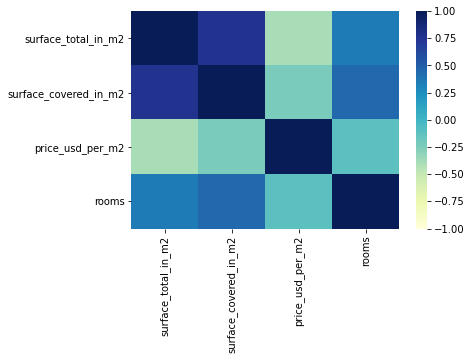

In [37]:
sns.heatmap(data.iloc[:, :4].corr(), vmin=-1, vmax=1, center=0, cmap="YlGnBu")

# **4.Supuestos de Markov**

import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.api as sm1. Linearidad de los parámetros
2. Los estimadores de los parámetros poblacionales se estiman a partir de una muestra aleatoria.
3. No hay colinealidad perfecta entre las variables explicativas.
4. El valor esperado del error es 0 para cualquier valor de la variable explicativa.
5. Homocedasticidad
6. Normalidad de los errores.
7. Independencia de los errores

## Linearidad del modelo

Para detectar la falta de linealidad, se pueden inspeccionar gráficas de valores observados frente a valores pronosticados o residuales frente a valores predichos. El resultado deseado es que los puntos se distribuyen simétricamente alrededor de una línea diagonal en la primera gráfica o alrededor de una línea horizontal en la última. En ambos casos con una varianza aproximadamente constante.

Observar un patrón "inclinado" indica que el modelo comete errores sistemáticos cada vez que realiza predicciones inusualmente grandes o pequeñas. Cuando el modelo contiene muchas características, la no linealidad también se puede revelar mediante patrones sistemáticos en las gráficas de los residuos frente a las características individuales.

Posibles soluciones:

- Transformaciones no lineales sobre las variables dependientes/independiente.
- Agregar features con transformaciones (por ejemplo una version de la variable al cuadrado, o arcsin, logaritmica, etc)
- Agregar features que no fueron considerados actualemente.

In [38]:
#linearidad del modelo
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(features, target):
    X = data[features]
    y = data[target]

    # Tenemos que agregar explícitamente a una constante:
    X = sm.add_constant(X)

    model = sm.OLS(y,X).fit()
    
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observados vs. Valores Predichos', fontsize=16)
    ax[0].set(xlabel='Predichos', ylabel='Observados')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residos vs. Valores Predichos', fontsize=16)
    ax[1].set(xlabel='Predichos', ylabel='Residuos')
    

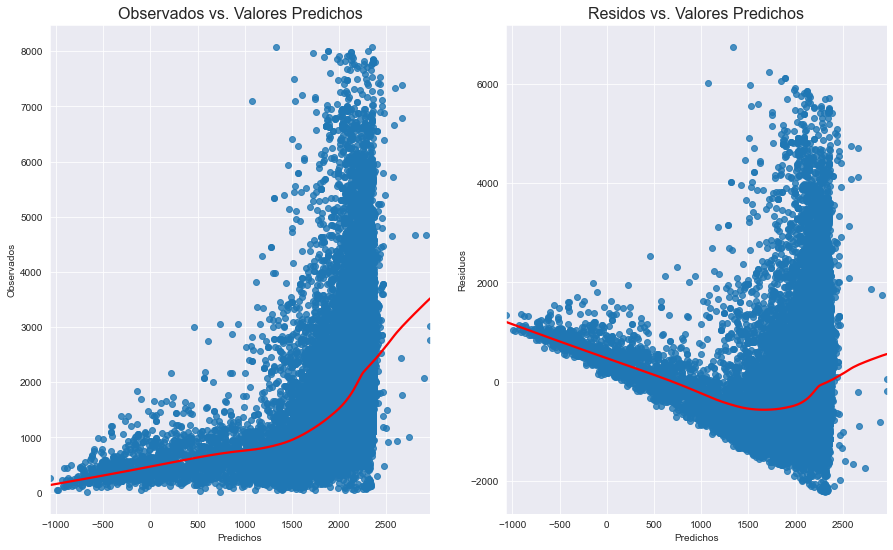

In [39]:
linearity_test(['surface_total_in_m2','surface_covered_in_m2','rooms'], ["price_usd_per_m2"])  

## Media de los errores

In [40]:
X = data[['surface_total_in_m2','surface_covered_in_m2','rooms']]
y = data["price_usd_per_m2"]
model = sm.OLS(y,X).fit()
model.resid.mean()

408.6906021537015

## Valor esperado de los errores

In [41]:
def residuals_test(features, target):
  X = data[features]
  y = data[target]

  # Tenemos que agregar explícitamente a una constante:
  X = sm.add_constant(X)

  model = sm.OLS(y, X).fit()
  residuals = model.resid

  p = sns.scatterplot(data = data, x = data[features], y = residuals);
  p.axhline(0, color = "green")
  p.set(ylabel = "Residuals");

  # otra opción:
  #sns.residplot(data = advertising, x = "TV", y = "Sales");

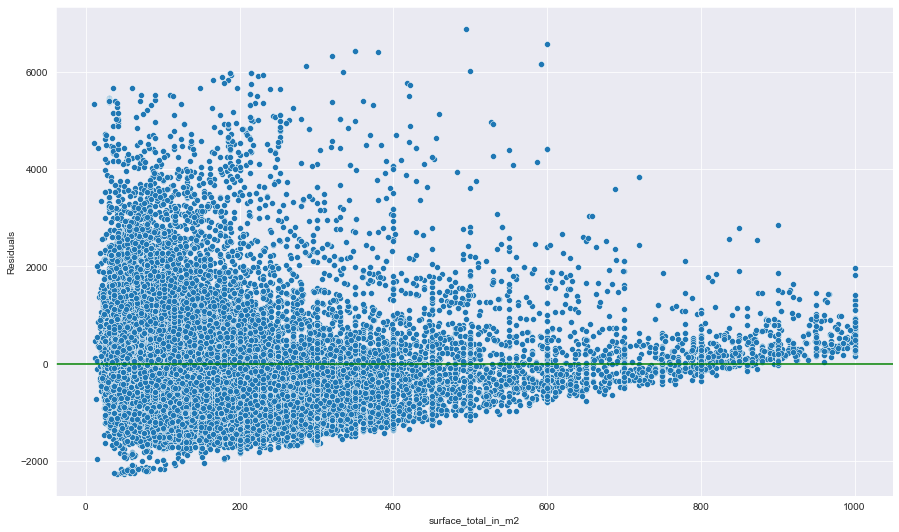

In [42]:
residuals_test('surface_total_in_m2', "price_usd_per_m2")

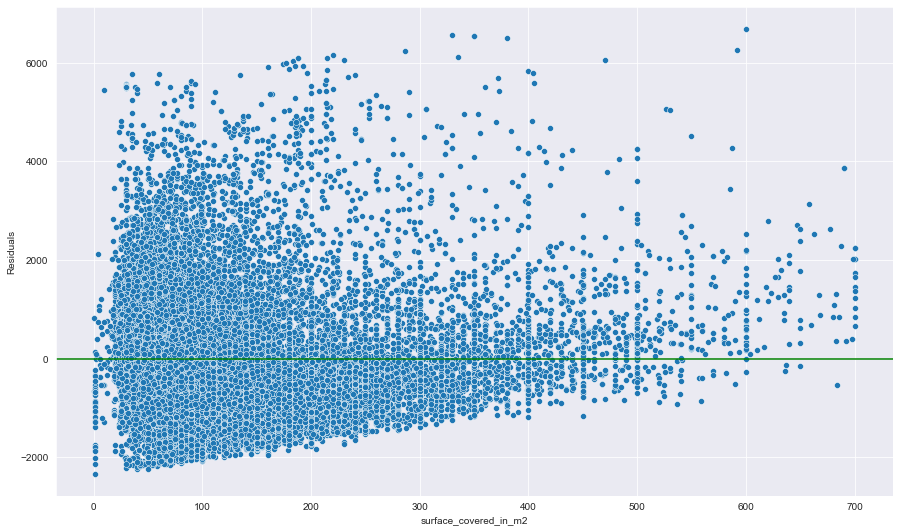

In [43]:
residuals_test('surface_covered_in_m2',"price_usd_per_m2")

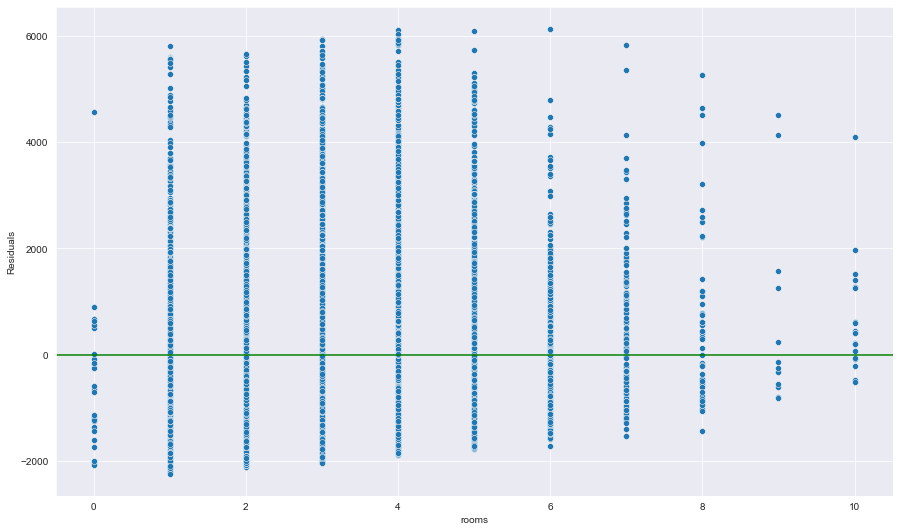

In [44]:
residuals_test("rooms", "price_usd_per_m2")

## Multicolinearidad



Para detectar multicolinealidad poder utilizar el factor de inflación de varianza (VIF). 
La interpretación de VIF es la siguiente: la raíz cuadrada de un VIF de una variable dada muestra cuánto más grande es el error estándar, en comparación con lo que sería si ese predictor no estuviera correlacionado con las otras características del modelo. Si no se correlacionan características, todos los valores para VIF serán 1.
Para lidiar con la multicolinealidad, debemos eliminar iterativamente las características con valores altos de VIF. Una regla general para la eliminación podría ser VIF mayor de 10 (5 también es común). 

In [45]:
#multicolinearidad uso IVF(inflación de varianza) muestra cuánto más grande es el error estándar, en comparación 
#con lo que sería si ese predictor no estuviera correlacionado con las otras características del modelo . 
#Si no se correlacionan características, todos los valores para VIF serán 1.

from statsmodels.stats.outliers_influence import variance_inflation_factor

def multicolinearidad_test (X):
  X_constant = sm.add_constant(X)
  vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
  return (pd.DataFrame({'vif': vif[1:]}, index=X.columns).T)

In [46]:
multicolinearidad_test(data[['surface_total_in_m2','surface_covered_in_m2','rooms']])

,surface_total_in_m2,surface_covered_in_m2,rooms
vif,2.479854,2.70879,1.249485


## Homocedasticidad

Para investigar si los residuos presentan igual varianza, podemos observar una gráfica de los residuos (o residuos estandarizados) frente a los valores predichos (ajustados) como hicimos en la figura anterior cuando chequeabamos la linealidad del modelo. Lo que debería alarmarnos es el caso cuando los residuos crecen ya sea en función del valor pronosticado o del tiempo (en el caso de series de tiempo).

También podemos usar dos pruebas estadísticas: Breusch-Pagan y Goldfeld-Quandt. En ambos, la hipótesis nula supone la homocedasticidad y un valor p por debajo de cierto nivel (como 0.05) indica que debemos rechazar el nulo a favor de la heterocedasticidad.

In [47]:
#homocedasticidad
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms

sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)


def homoscedasticity_test(features, target):
    X = data[features]
    y = data[target]
   
    model = sm.OLS(y,X).fit()
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    #Breusch-Pagan Test
    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])
    
    #Goldfeld-Quandt test
    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')


 Breusch-Pagan test ----
                                     value
Lagrange multiplier statistic  8529.725649
p-value                           0.000000
f-value                        3572.803825
f p-value                         0.000000

 Goldfeld-Quandt test ----
                value
F statistic  0.992474
p-value      0.707385

 Residuals plots ----


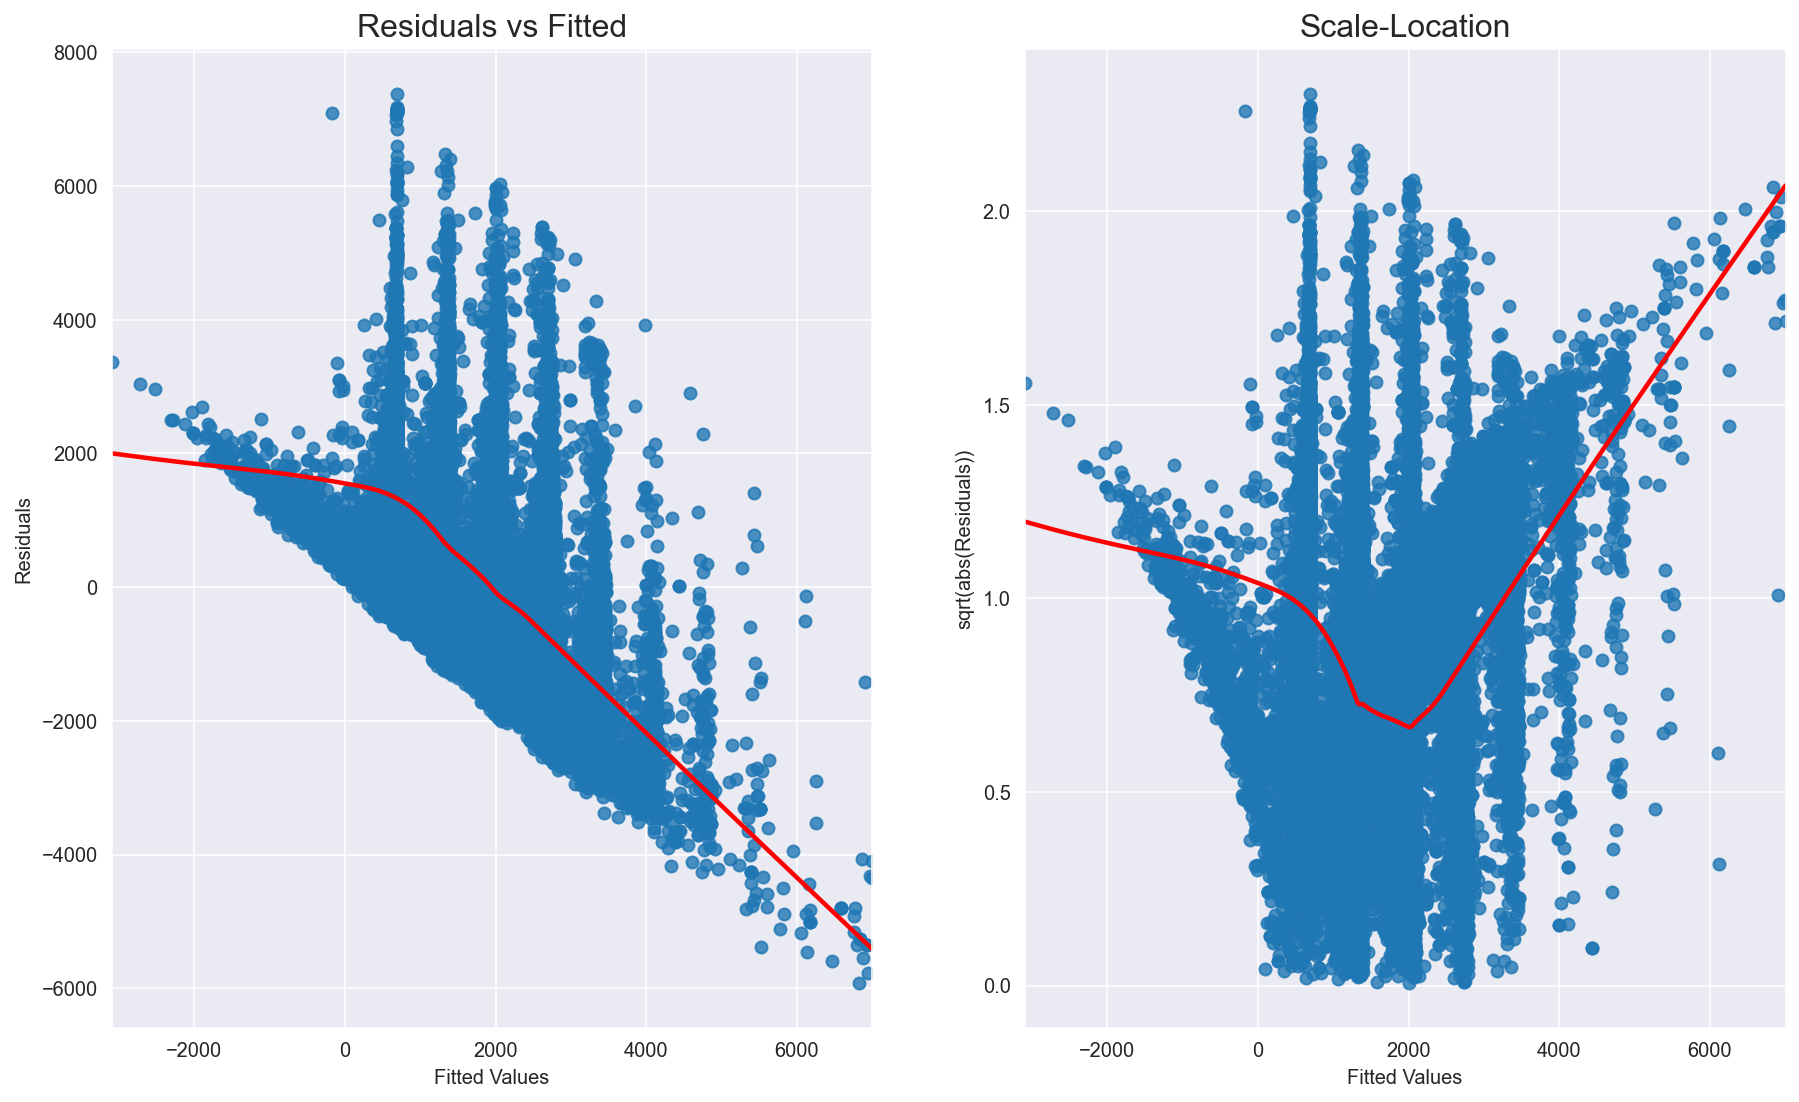

In [48]:
homoscedasticity_test(['surface_total_in_m2','surface_covered_in_m2','rooms'], ["price_usd_per_m2"])

## Autocorrelación

Para investigar si la autocorrelación está presente, utilizo gráficos ACF (función de autocorrelación) y la prueba de Durbin-Watson. En el primer caso, queremos ver si el valor de ACF es significativo para cualquier retraso (en caso de que no haya datos de series temporales, se utiliza el número de fila). Al llamar a la función, indicamos el nivel de significación en el que estamos interesados y el área crítica se traza en el gráfico. Las correlaciones significativas se encuentran fuera de esa área.

Algunas notas sobre la prueba de Durbin-Watson:

- El estadistico de prueba siempre tiene un valor entre 0 y 4
- El valor de 2 significa que no hay autocorrelación en la muestra
- Valores <2 indican autocorrelación positiva, valores > 2 negativo uno. Si vamos a la celda donde obtuvimos el modelo vemos un DW = 1.016



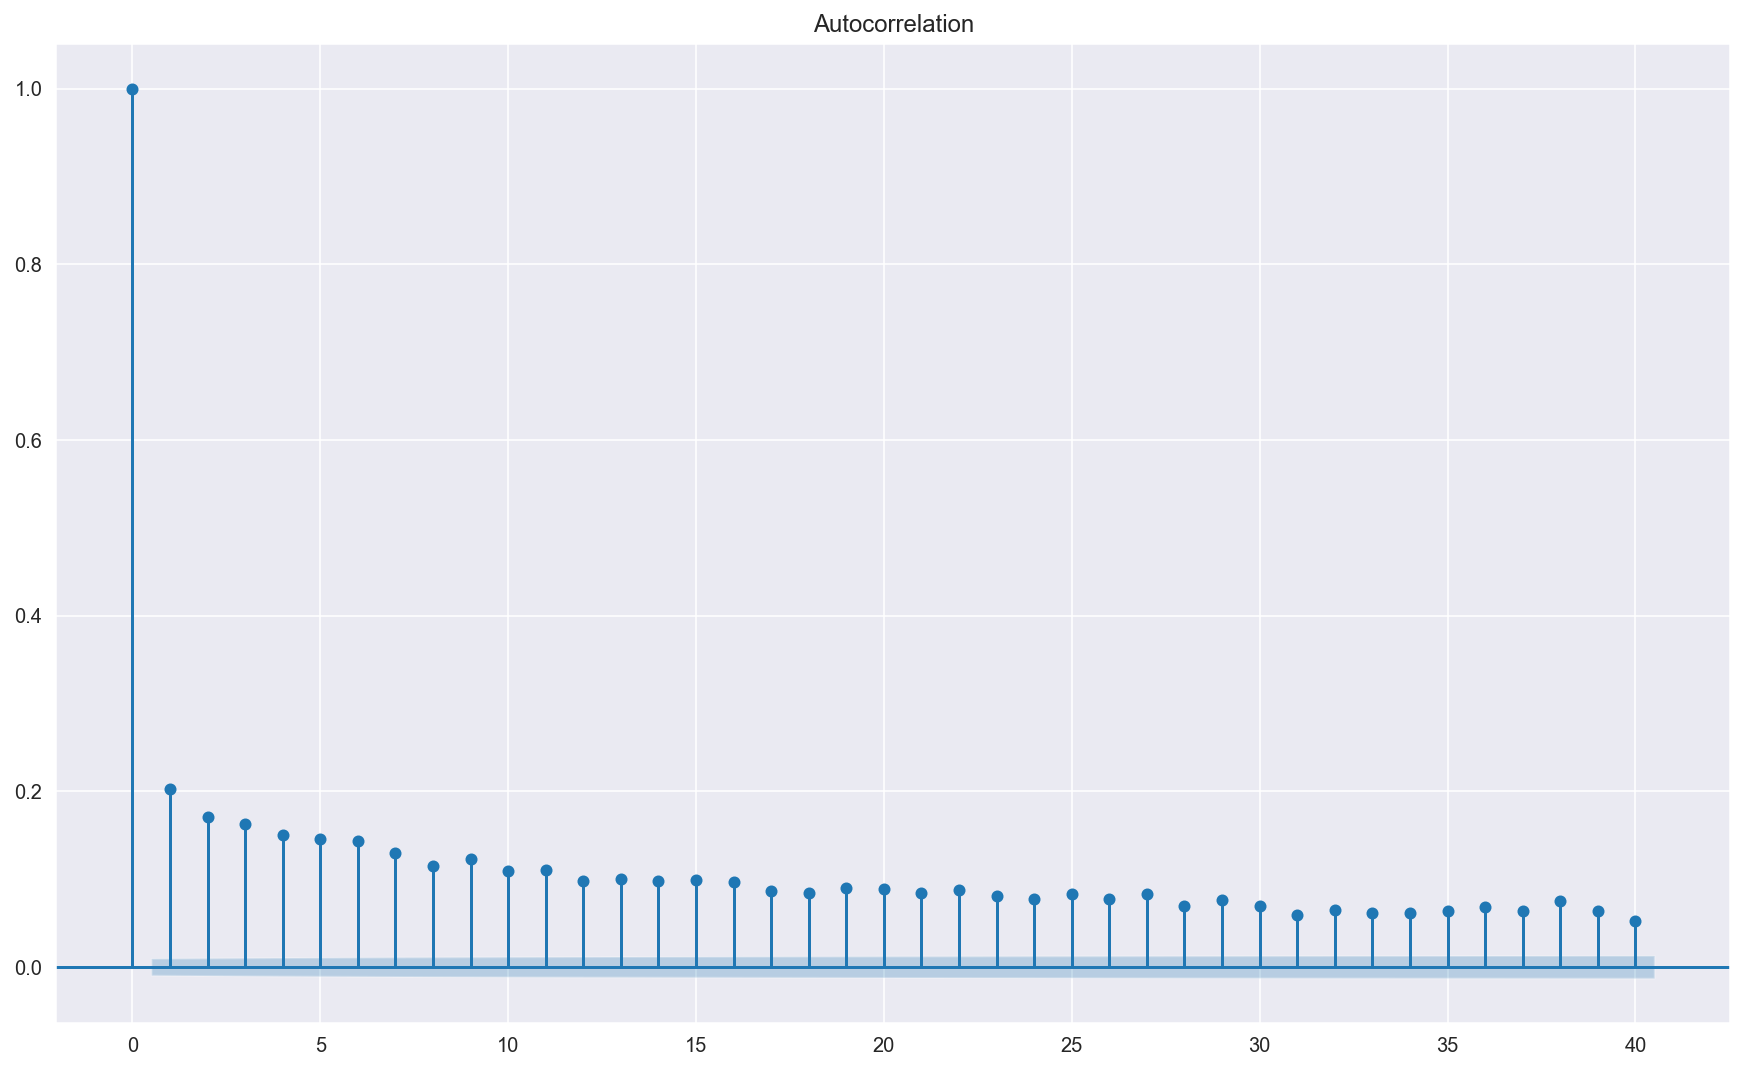

In [49]:
#autocorrelacion
import statsmodels.tsa.api as smt

X = data[['surface_total_in_m2','surface_covered_in_m2','rooms']]
y = data["price_usd_per_m2"]
model = sm.OLS(y,X).fit()

acf = smt.graphics.plot_acf(model.resid, lags=40 , alpha=0.05)
#acf.show();

## Normalidad de los residuos

Cuando se viola este supuesto , puede causar problemas al calcular los intervalos de confianza y varias pruebas de significancia para los coeficientes. Cuando la distribución del error se aleja significativamente de Gauss, los intervalos de confianza pueden ser demasiado amplios o demasiado estrechos. Algunas de las posibles razones que causan residuos no normales:

- Presencia de algunos valores atípicos grandes en los datos
- Puede haber otros problemas (violaciones) con los supuestos del modelo
- Otra mejor especificación del modelo podría ser más adecuada para este problema.

Para investigar esta suposición podemos mirar:

- Gráficos QQ de los residuos. Por ejemplo, un patrón de desviaciones en forma de arco de la diagonal implica que los residuos tienen una inclinación excesiva (es decir, la distribución no es simétrica, con demasiados residuos grandes en una dirección). El patrón de desviaciones en forma de s implica una curtosis excesiva de los residuos: hay demasiados o dos pocos errores grandes en ambas direcciones.
- Pruebas estadísticas como la prueba de Kolmogorov-Smirnov, la prueba de Shapiro-Wilk, la prueba de Jarque-Bera y la prueba de Anderson-Darling pueden ser utiles para evaluar este supuesto.

Posibles soluciones:
- transformación no lineal de la variable o características objetivo
- eliminar / tratar posibles valores atípicos
- Puede suceder que haya dos o más subconjuntos de datos que tengan propiedades estadísticas diferentes, en cuyo caso podrían considerarse modelos separados

In [49]:
#normalidad de los residuos
from scipy import stats

def normality_of_residuals_test(features, target):
    X = data[features]
    y = data[target]
    model = sm.OLS(y,X).fit()
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')

C:\Users\maela\anaconda3\envs\dhdsblend2021\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Jarque-Bera test ---- statistic: 2217.9125, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9923, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.6274, p-value: 0.0000
Anderson-Darling test ---- statistic: 40.7737, 5% critical value: 0.7870
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


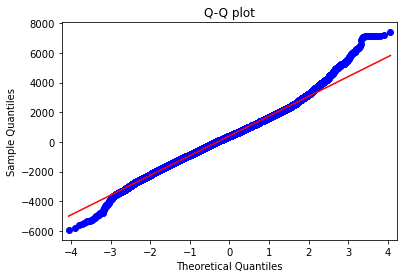

In [50]:
normality_of_residuals_test(['surface_total_in_m2','surface_covered_in_m2','rooms'], ["price_usd_per_m2"])

<AxesSubplot:ylabel='Density'>

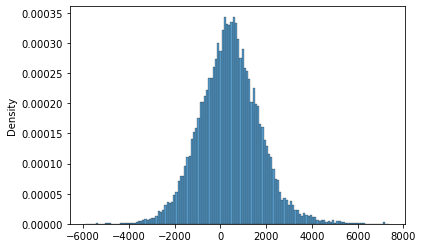

In [51]:
sns.histplot(model.resid, kde = False, stat = 'density', line_kws={'linewidth':5})

# **5.Modelos**

## **REGRESION LINEAL SIMPLE**

### De a una feature a la vez sin normalizar

In [52]:
X1 = data[['surface_total_in_m2']]
X2 = data[['surface_covered_in_m2']]
X3 = data[['rooms']]
y = data['price_usd_per_m2']

In [53]:
X1train, X1test, y1train, y1test = train_test_split(X1, y, random_state = 1)
X2train, X2test, y2train, y2test = train_test_split(X2, y, random_state = 1)
X3train, X3test, y3train, y3test = train_test_split(X3, y, random_state = 1)

In [54]:
lm = LinearRegression() # Fiteamos el modelo sobre los vectores X e y.

array([-2.60476694])

2486.650029615513

array([2332.96878008, 2330.36401314, 2127.19219172, ..., 2390.27365279,
       2382.45935197, 2366.83075032])

MAE	700.94
MSE	944445.18
RMSE	971.83
R2	0.16


<AxesSubplot:xlabel='surface_total_in_m2', ylabel='price_usd_per_m2'>

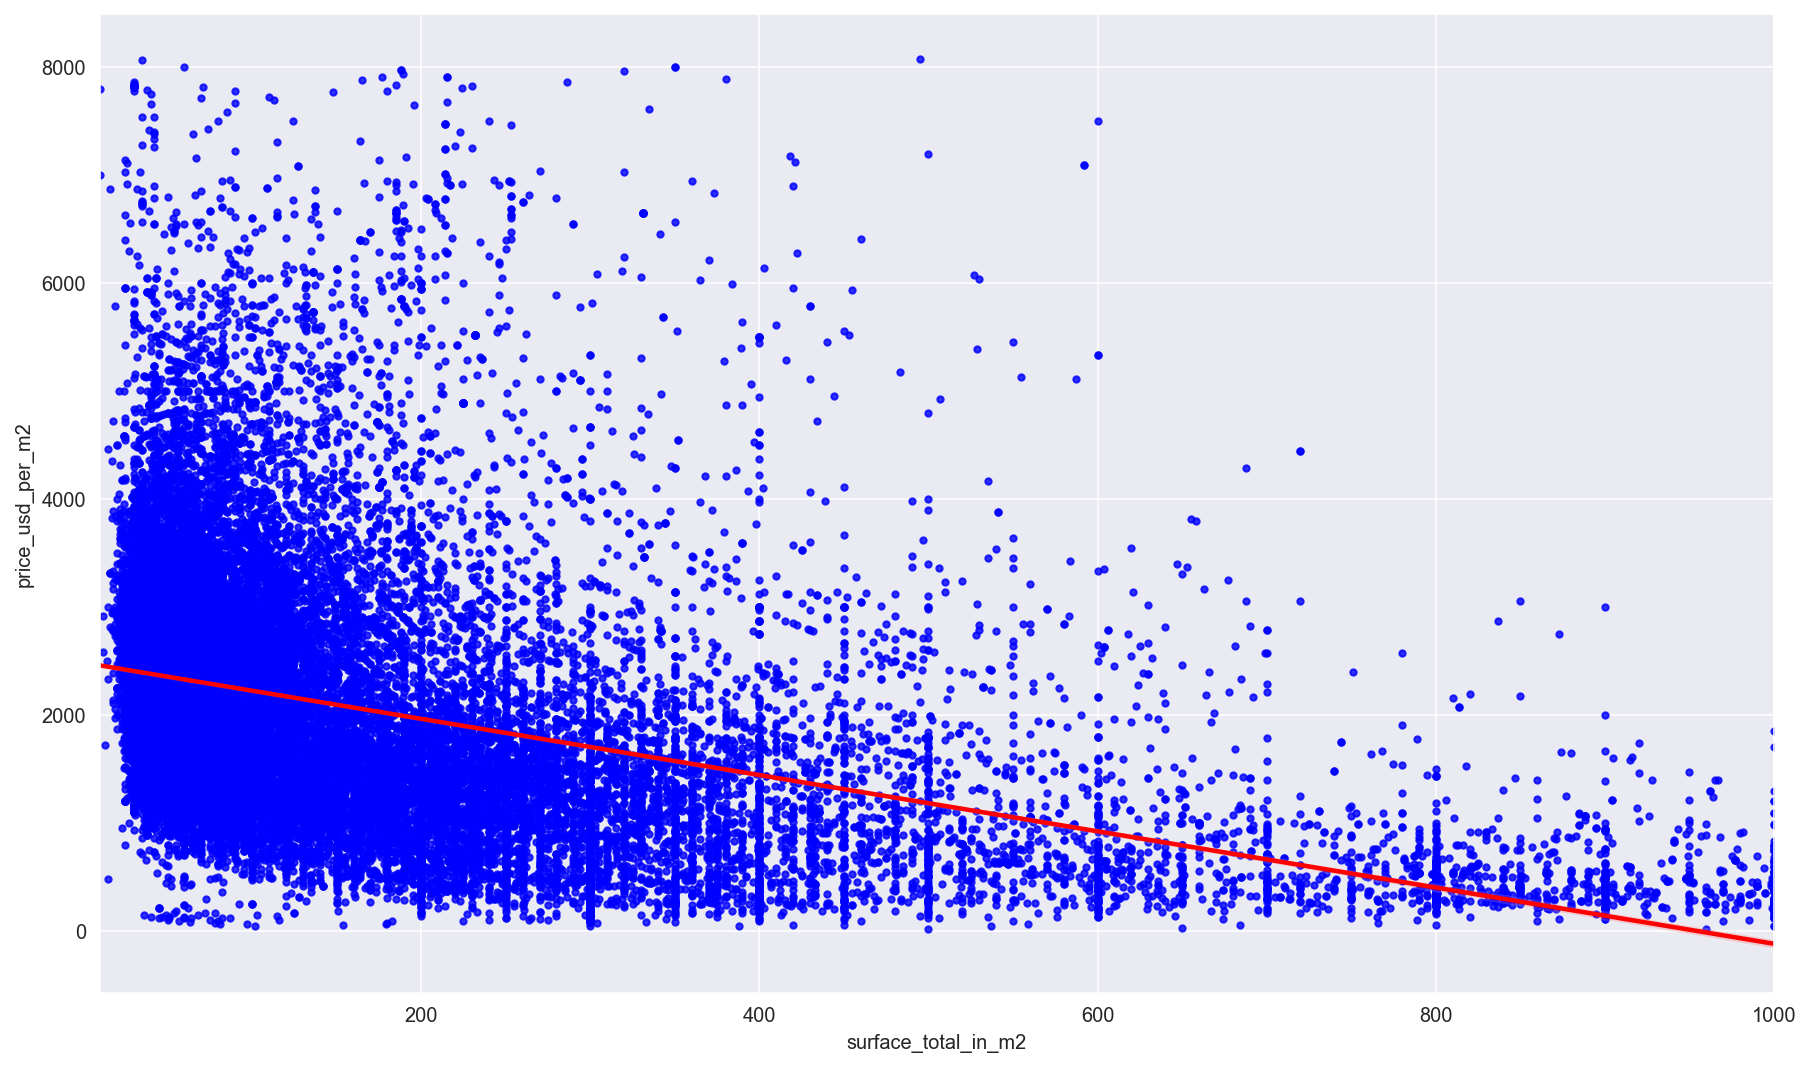

In [55]:
# Superficie total
model1 = lm.fit(X1, y)
model1.coef_
model1.intercept_
test_sklearn_1 = np.array(X1test).reshape(-1,1)
model1.predict(test_sklearn_1)
y1pred = model1.predict(X1test)

print(f'''MAE\t{mean_absolute_error(y1test, y1pred).round(2)}
MSE\t{mean_squared_error(y1test, y1pred).round(2)}
RMSE\t{np.sqrt(mean_squared_error(y1test, y1pred)).round(2)}
R2\t{r2_score(y1test, y1pred).round(2)}''')

sns.regplot(data = data, x = 'surface_total_in_m2', y = 'price_usd_per_m2', ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"})

array([-2.61384529])

2381.775005041239

array([2258.92427649, 2251.08274062, 2021.06435524, ..., 2290.29041995,
       2277.22119351, 2277.22119351])

MAE	748.4
MSE	1057673.79
RMSE	1028.43
R2	0.06


<AxesSubplot:xlabel='surface_covered_in_m2', ylabel='price_usd_per_m2'>

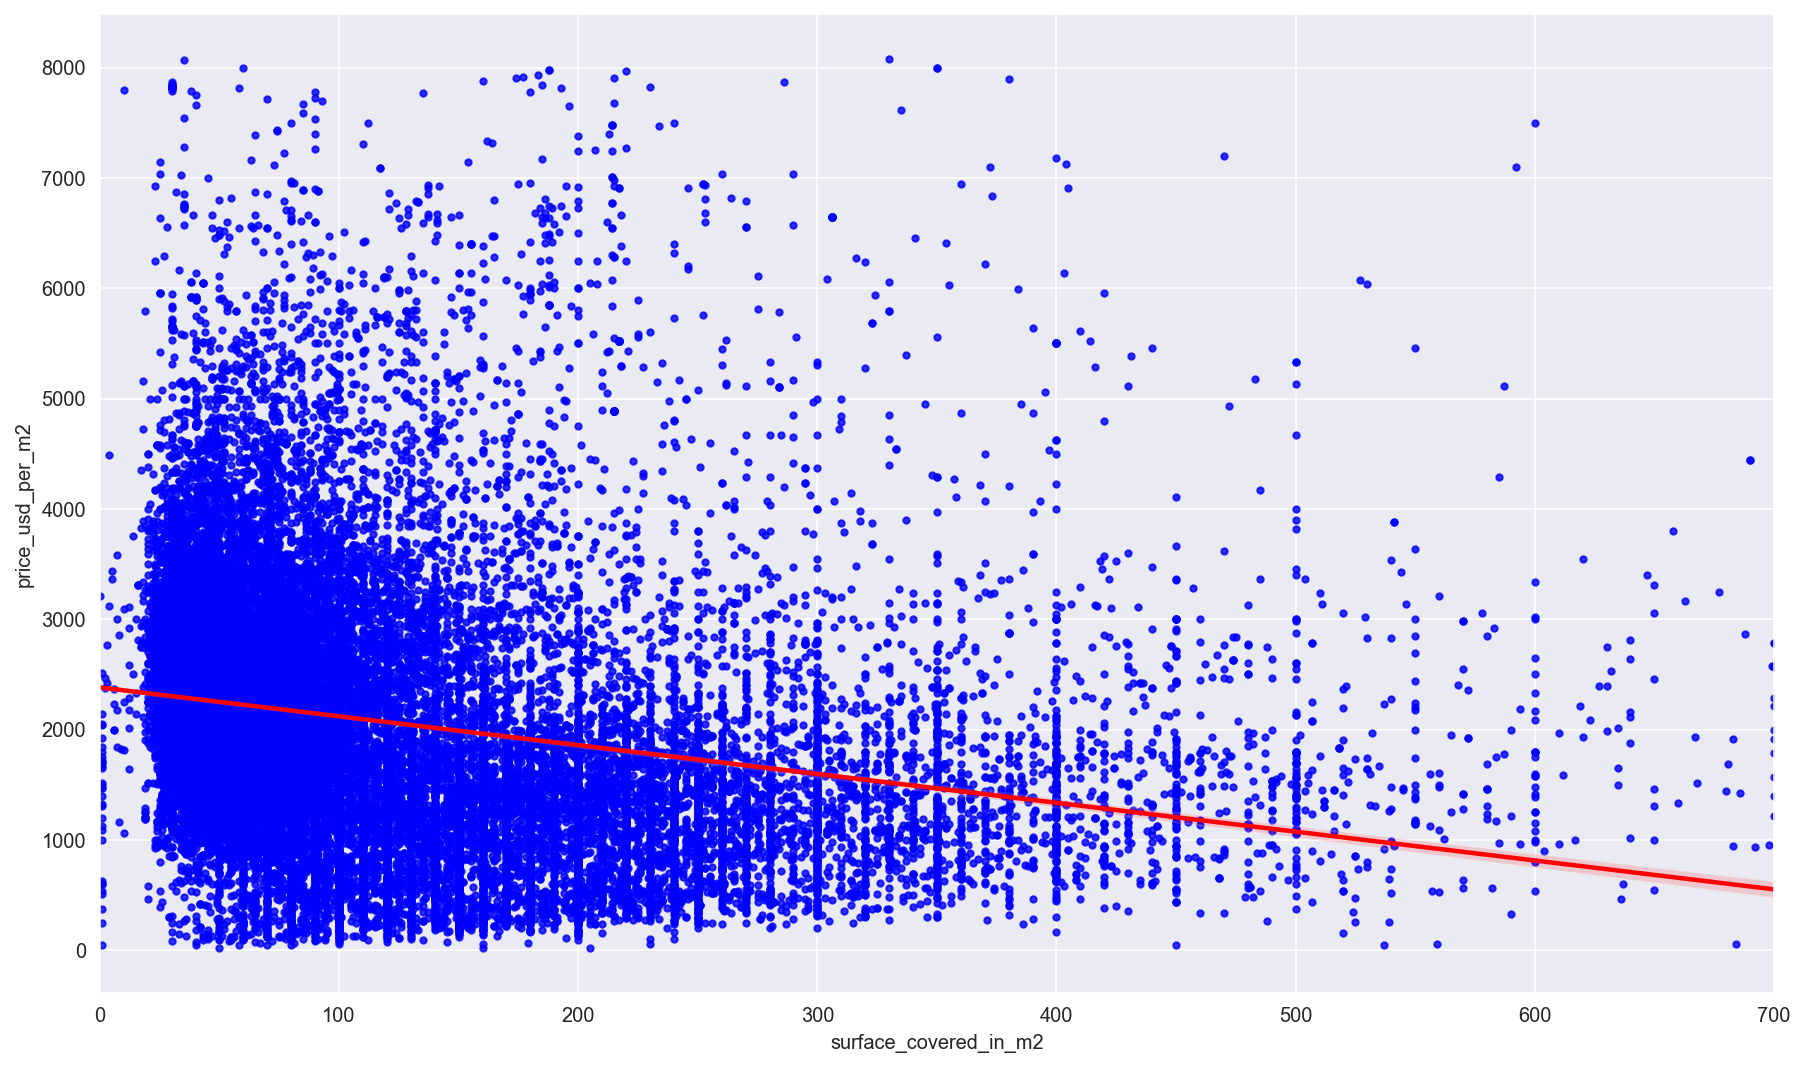

In [56]:
# Superficie cubierta
model2 = lm.fit(X2, y)
model2.coef_
model2.intercept_
test_sklearn_2 = np.array(X2test).reshape(-1,1)
model2.predict(test_sklearn_2)
y2pred = model2.predict(X2test)

print(f'''MAE\t{mean_absolute_error(y2test, y2pred).round(2)}
MSE\t{mean_squared_error(y2test, y2pred).round(2)}
RMSE\t{np.sqrt(mean_squared_error(y2test, y2pred)).round(2)}
R2\t{r2_score(y2test, y2pred).round(2)}''')

sns.regplot(data = data, x = 'surface_covered_in_m2', y = 'price_usd_per_m2', ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"})

array([-96.71856822])

2353.1539851961998

array([2159.71684875, 2159.71684875, 1869.56114408, ..., 2256.43541697,
       2159.71684875, 2159.71684875])

MAE	781.27
MSE	1109205.16
RMSE	1053.19
R2	0.01


<AxesSubplot:xlabel='rooms', ylabel='price_usd_per_m2'>

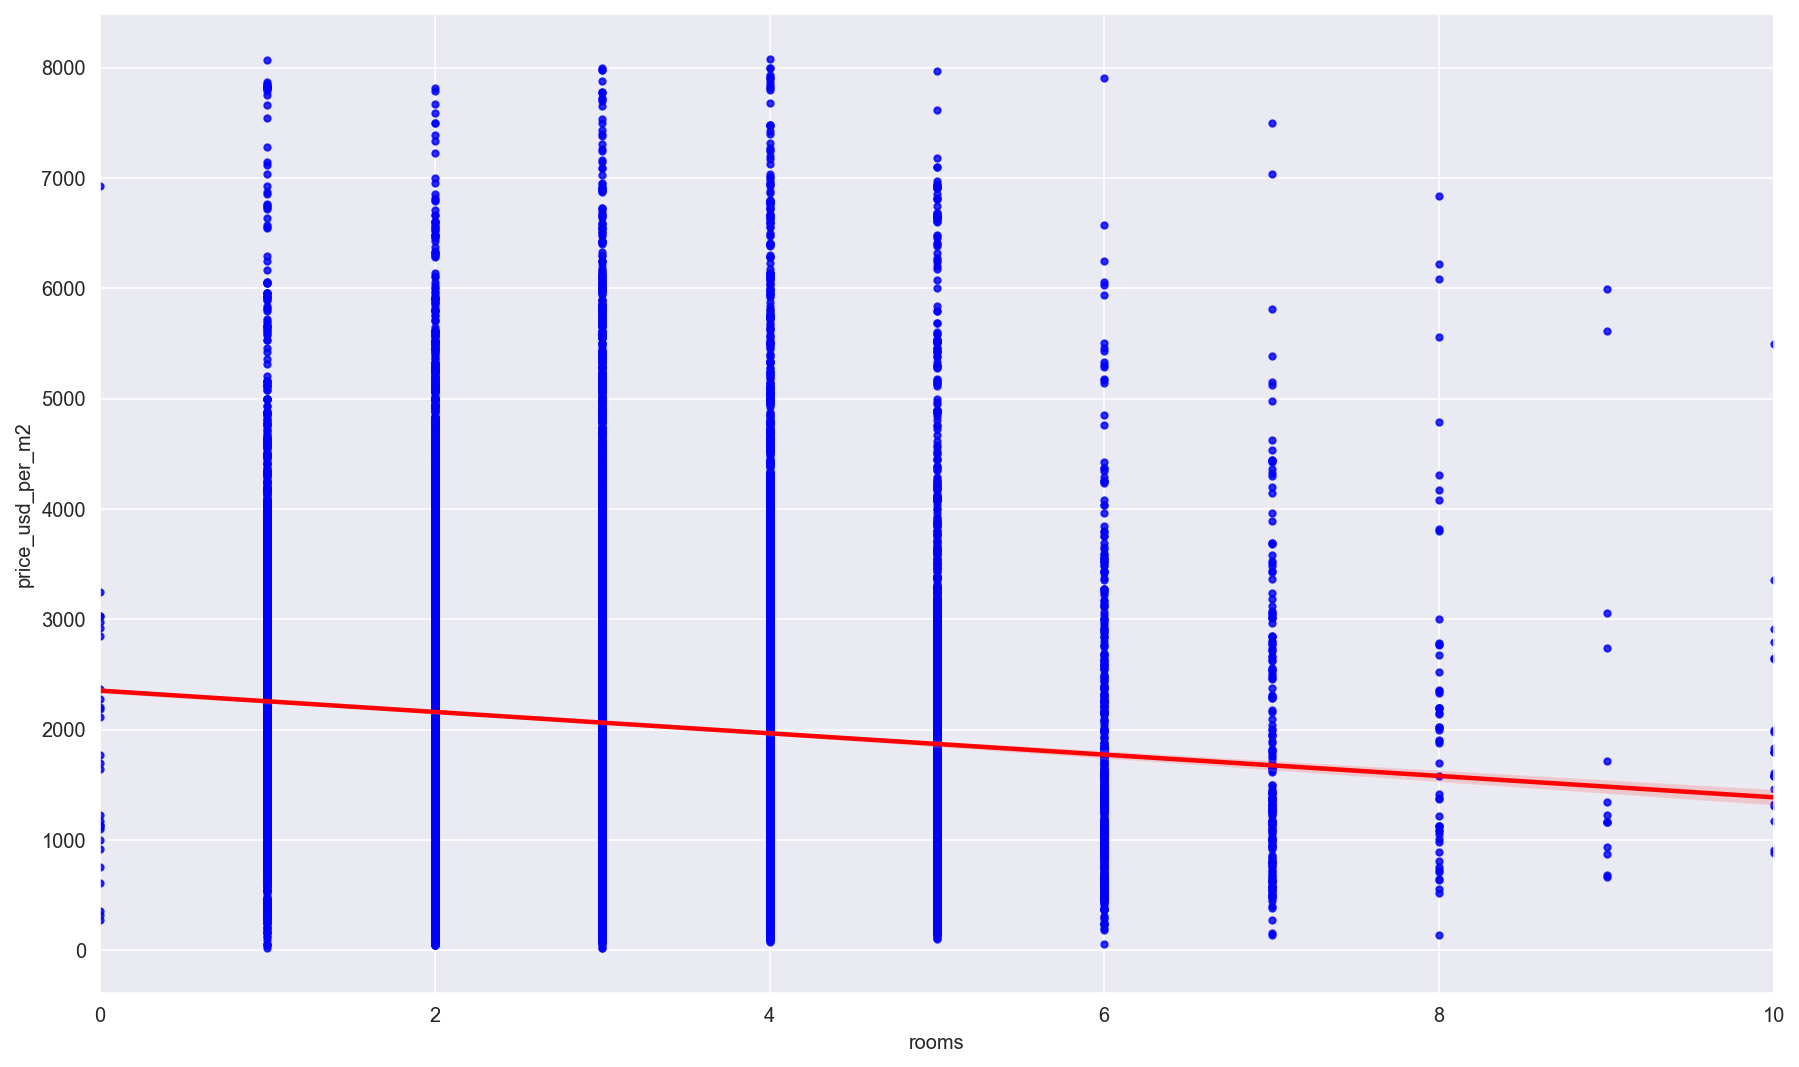

In [57]:
# Habitaciones
model3 = lm.fit(X3, y)
model3.coef_
model3.intercept_
test_sklearn_3 = np.array(X3test).reshape(-1,1)
model3.predict(test_sklearn_3)
y3pred = model3.predict(X3test)

print(f'''MAE\t{mean_absolute_error(y3test, y3pred).round(2)}
MSE\t{mean_squared_error(y3test, y3pred).round(2)}
RMSE\t{np.sqrt(mean_squared_error(y3test, y3pred)).round(2)}
R2\t{r2_score(y3test, y3pred).round(2)}''')

sns.regplot(data = data, x = 'rooms', y = 'price_usd_per_m2', ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"})

### De a una feature a la vez normalizando

In [52]:
X1 = data[['surface_total_in_m2']]
X2 = data[['surface_covered_in_m2']]
X3 = data[['rooms']]
y = data['price_usd_per_m2']

array([-0.39781692])

1.0691844987508771e-16

array([0.22307227, 0.22058726, 0.02675668, ..., 0.27774244, 0.27028741,
       0.25537737])

MAE	0.66
MSE	0.84
RMSE	0.92
R2	0.16


<AxesSubplot:xlabel='surface_total_in_m2'>

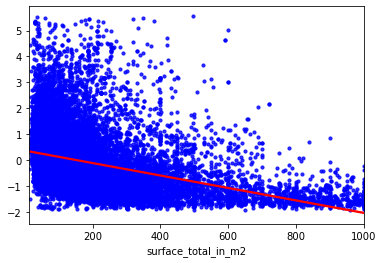

In [53]:
# Aplico modelo sobre variables normalizadas Surface_total_in_m2
X1train, X1test, y1train, y1test = train_test_split(X1, y, random_state = 1)
lms = LinearRegression() # Fiteamos el modelo sobre los vectores xs e ys.

X1strain = preprocessing.scale(X1train)
y1strain = preprocessing.scale(y1train)

models = lms.fit(X1strain, y1strain)
models.coef_
models.intercept_
test_sklearn_s = np.array(X1stest).reshape(-1,1)
models.predict(test_sklearn_s)
yspred = models.predict(X1test)

print(f'''MAE\t{mean_absolute_error(y1test, yspred).round(2)}
MSE\t{mean_squared_error(y1test, yspred).round(2)}
RMSE\t{np.sqrt(mean_squared_error(y1test, yspred)).round(2)}
R2\t{r2_score(y1test, yspred).round(2)}''')

sns.regplot(data = data, x = X1train, y = y1strain, ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"})

array([-0.23023624])

7.971503264520548e-17

array([ 0.15248656,  0.14517576, -0.06927422, ...,  0.18172974,
        0.16954508,  0.16954508])

MAE	0.71
MSE	0.94
RMSE	0.97
R2	0.06


<AxesSubplot:xlabel='surface_covered_in_m2'>

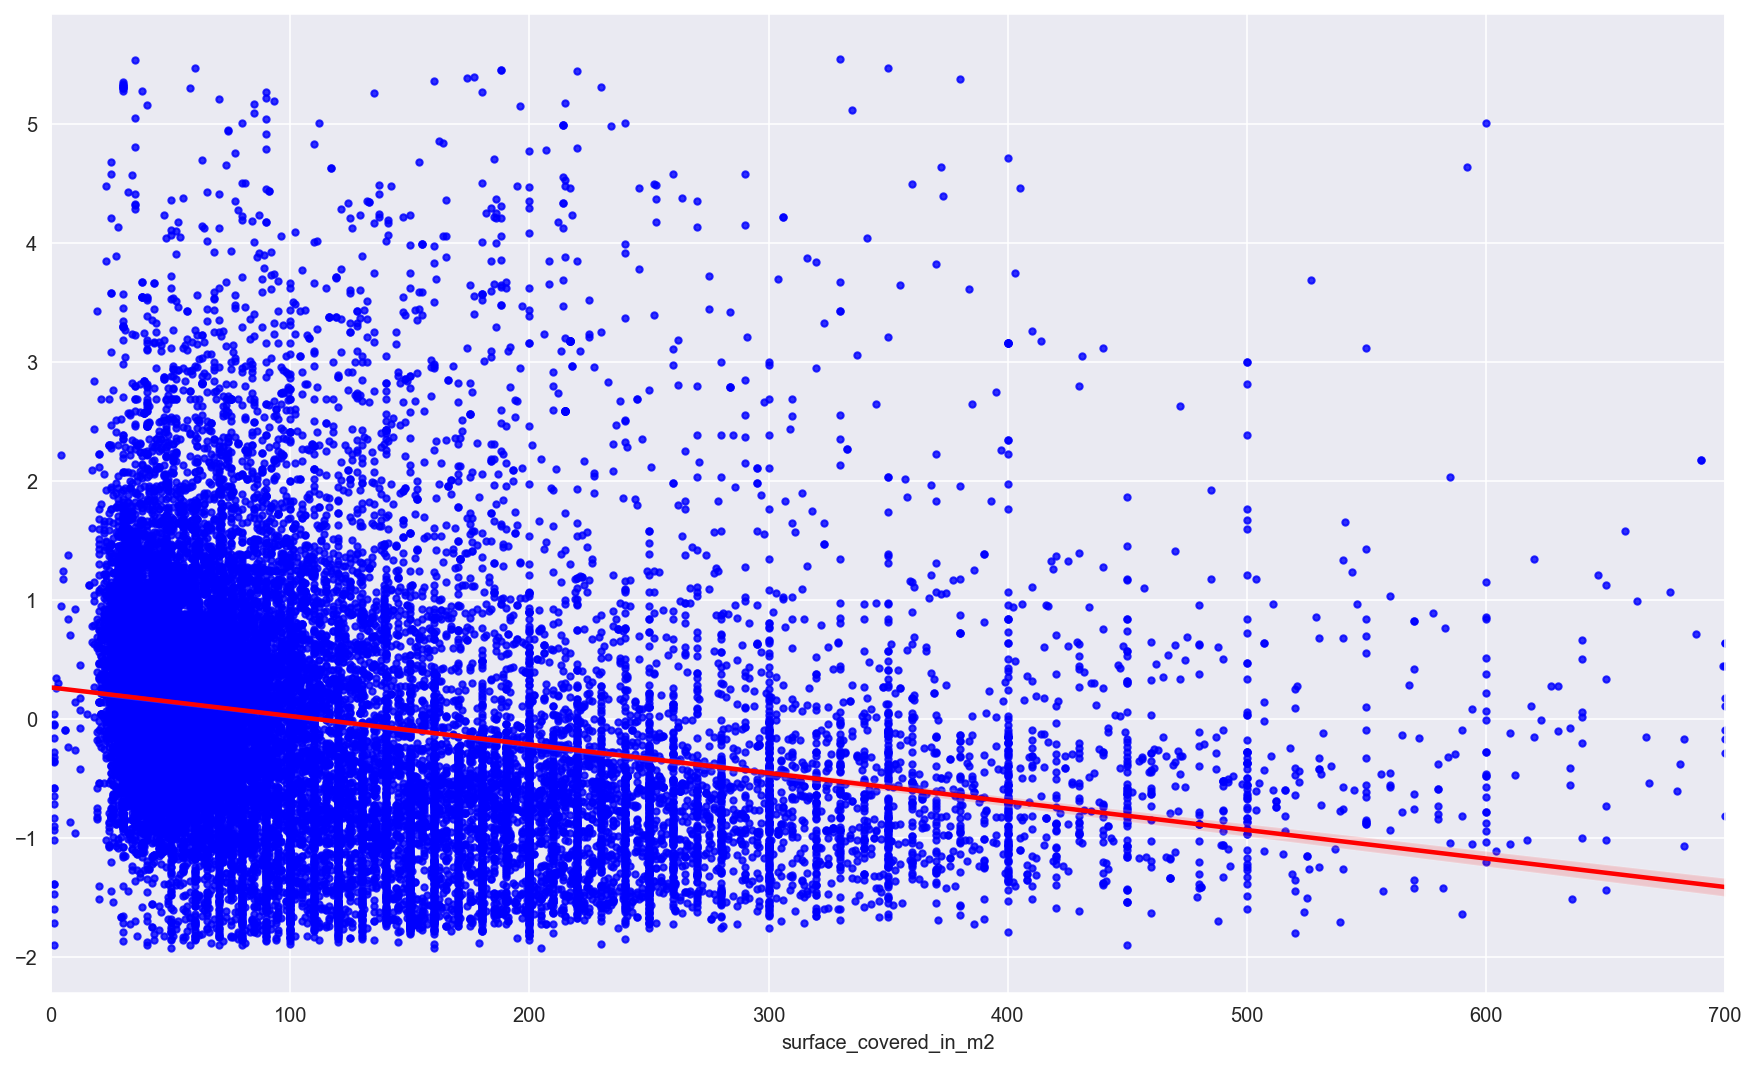

In [80]:
# Aplico modelo sobre variables normalizadas Surface_covered_in_m2
X2train, X2test, y2train, y2test = train_test_split(X2, y, random_state = 1)
lms = LinearRegression() # Fiteamos el modelo sobre los vectores xs e ys.

X2strain = preprocessing.scale(X2train)
y2strain = preprocessing.scale(y2train)

models = lms.fit(X2strain, y2strain)
models.coef_
models.intercept_
test_sklearn_s = np.array(X2stest).reshape(-1,1)
models.predict(test_sklearn_s)
yspred = models.predict(X2test)

print(f'''MAE\t{mean_absolute_error(y2test, yspred).round(2)}
MSE\t{mean_squared_error(y2test, yspred).round(2)}
RMSE\t{np.sqrt(mean_squared_error(y2test, yspred)).round(2)}
R2\t{r2_score(y2test, yspred).round(2)}''')

sns.regplot(data = data, x = X2train, y = y2strain, ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"})

array([-0.10923268])

8.921390181072155e-17

array([ 0.06156681,  0.06156681, -0.21002087, ...,  0.15209604,
        0.06156681,  0.06156681])

MAE	0.74
MSE	0.99
RMSE	0.99
R2	0.01


<AxesSubplot:xlabel='rooms'>

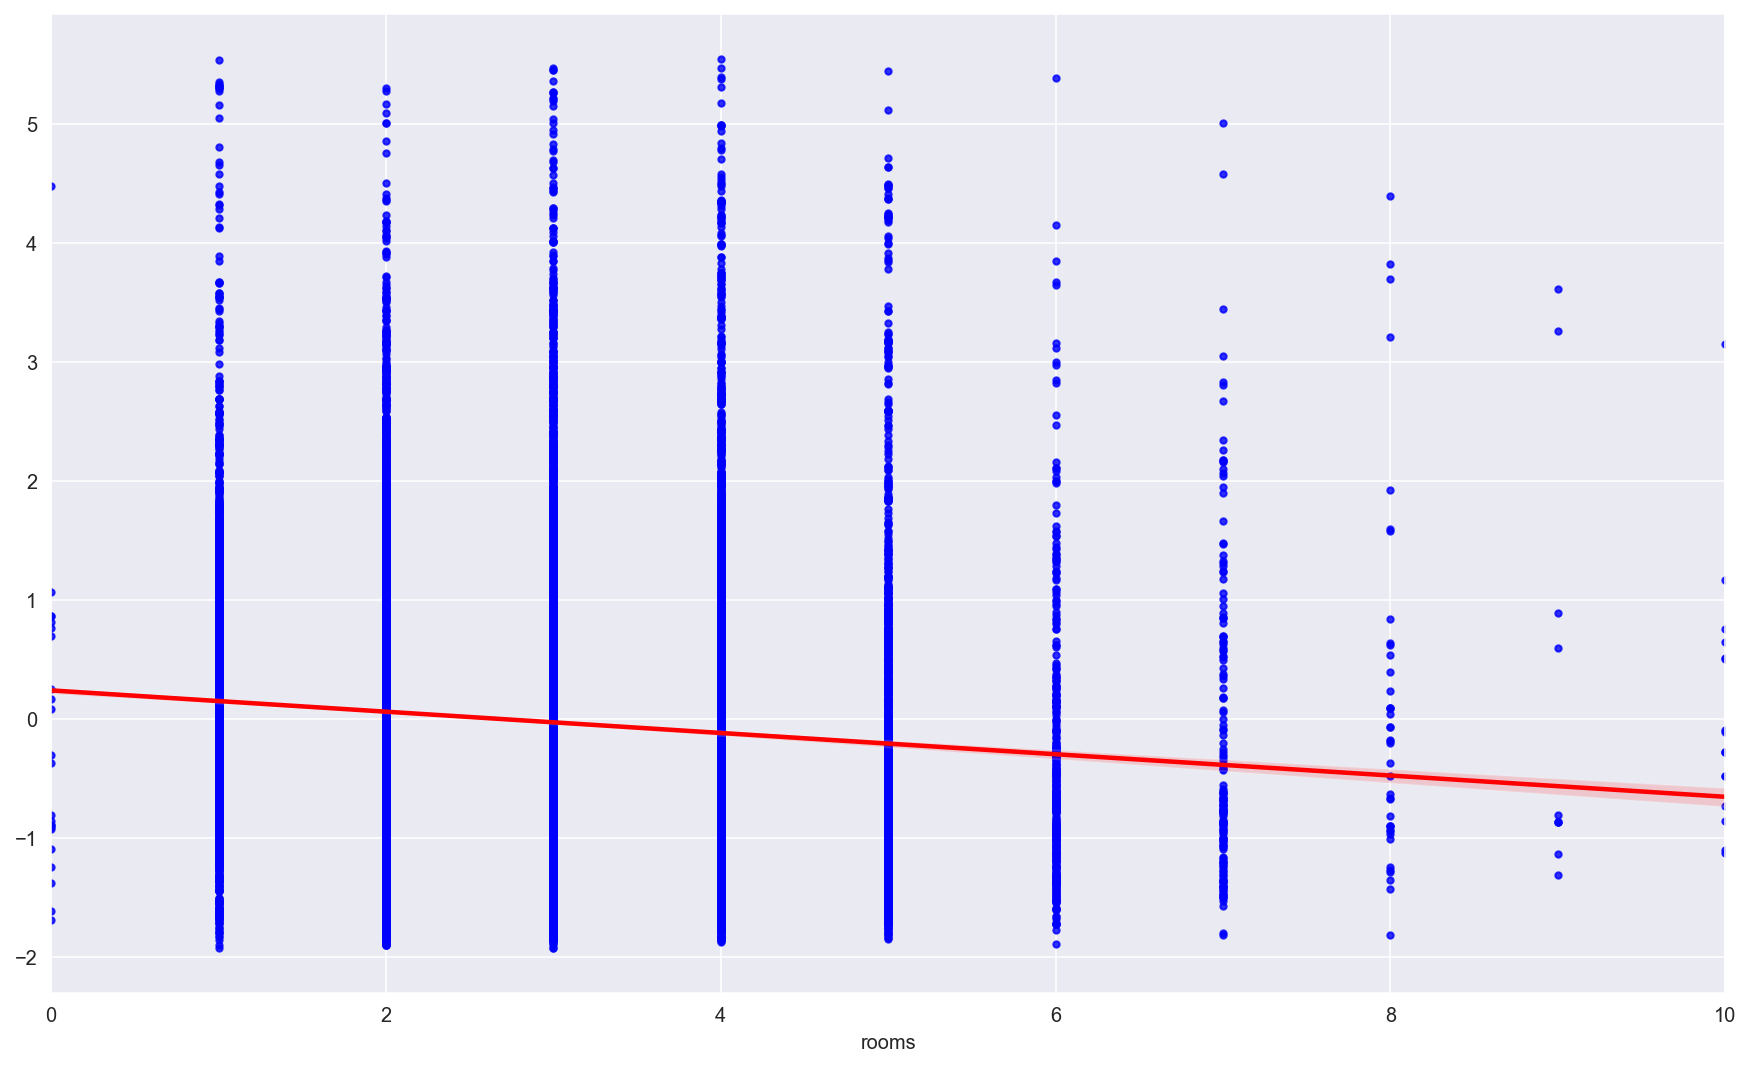

In [81]:
# Aplico modelo sobre variables normalizadas rooms
X3train, X3test, y3train, y3test = train_test_split(X3, y, random_state = 1)
lms = LinearRegression() # Fiteamos el modelo sobre los vectores xs e ys.

X3strain = preprocessing.scale(X3train)
y3strain = preprocessing.scale(y3train)


models = lms.fit(X3strain, y3strain)
models.coef_
models.intercept_
test_sklearn_s = np.array(X3stest).reshape(-1,1)
models.predict(test_sklearn_s)
yspred = models.predict(X3test)

print(f'''MAE\t{mean_absolute_error(y3test, yspred).round(2)}
MSE\t{mean_squared_error(y3test, yspred).round(2)}
RMSE\t{np.sqrt(mean_squared_error(y3test, yspred)).round(2)}
R2\t{r2_score(y3test, yspred).round(2)}''')

sns.regplot(data = data, x = X3train, y = y3strain, ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"})

## **REGRESION LINEAL MULTIPLE**

### Creo una funcion que tome features y aplique RLM y devuelva MAE

In [60]:
# Definimos una función que acepta una lista de features, hace el split entre train y test,
# reservando un 25% de las observaciones para testeo, y devuelve la prueba MAE.

def train_test_mae(feature_cols):
    X = data[feature_cols]
    y = data.price_usd_per_m2
    # Como estamos trabajando con observaciones ordenadas en el tiempo, ponemos
    # shuffle=False para evitar data leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return metrics.mean_absolute_error(y_test, y_pred)

In [61]:
train_test_mae(['surface_total_in_m2','surface_covered_in_m2','rooms'])

705.1883861779858

### Con las tres features originales sin normalizar

In [54]:
# Hacemos un modelo utilizando las 3 variables independientes para predecir price_usd_per_m2
X = data[['surface_total_in_m2','surface_covered_in_m2','rooms']]
y = data['price_usd_per_m2']

# Separar entre train y test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

# Importamos, Instanciamos, Fiteamos, etc..

# Instanciamos el modelo.
lm = LinearRegression()

# Fiteamos el modelo sobre los vectores X e y.
model = lm.fit(X_train, y_train)
#
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
predictions = lm.predict(X_test)

# Imprimimos el intercepto y los coeficientes como atributos del objeto entrenado.
print ('Intercepto=', ' ', model.intercept_)
print ('RM=', ' ', model.coef_)
print ('MAE:', metrics.mean_absolute_error(y, predictions))
print ('MSE:', metrics.mean_squared_error(y, predictions))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y, predictions)))
print ('R2:', metrics.r2_score(y, predictions))

Intercepto=   2400.626030768864
RM=   [-3.53810322  2.0755816  -0.66875455]
MAE: 711.1531114544409
MSE: 954469.8834707387
RMSE: 976.9697454224151
R2: 0.17220192336237305


Text(0.5, 0, 'Predicciones usando todas las variables')

Text(0, 0.5, 'Valores reales ')

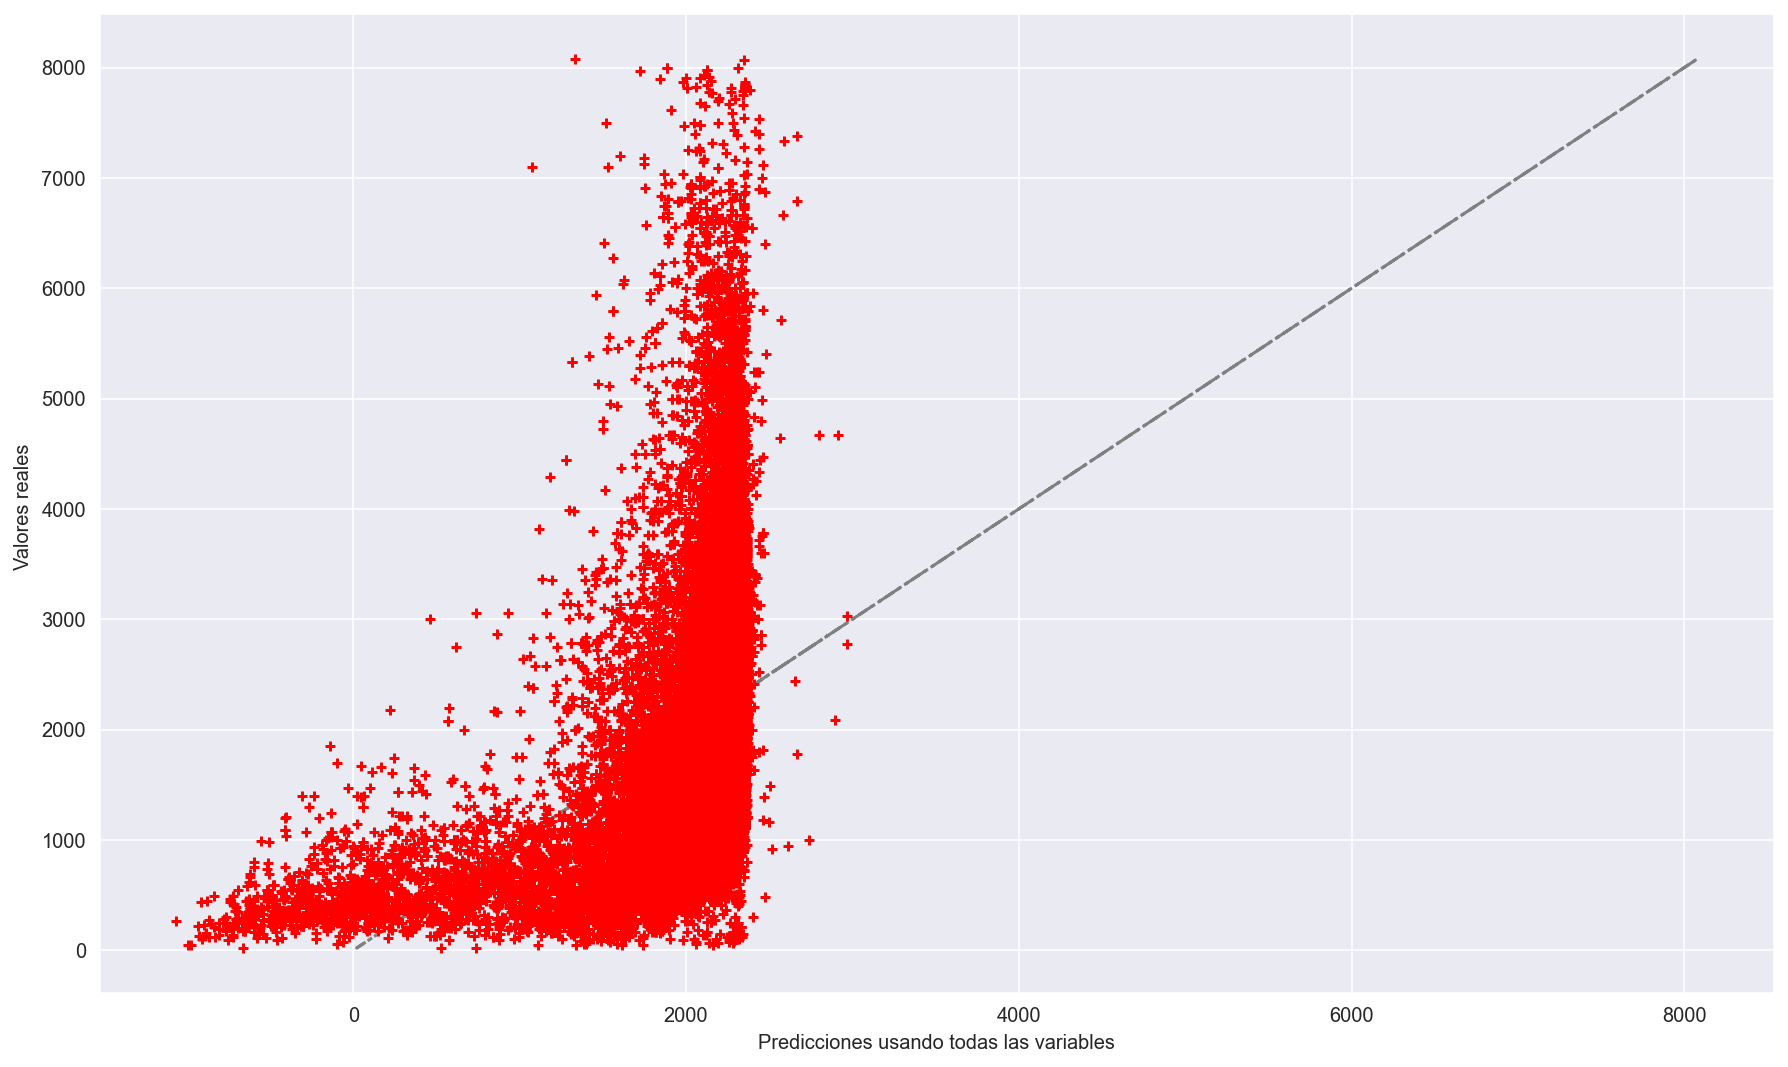

In [141]:
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones usando todas las variables")
plt.ylabel("Valores reales ")
plt.show()

### Con las tres features originales **con normalización**

In [55]:
X_orig = data[['surface_total_in_m2','surface_covered_in_m2','rooms']]
y_orig = data["price_usd_per_m2"]

In [56]:
# Separar entre train y test
X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(X_orig, y_orig)

#Normalizamos
Xs_orig_train = preprocessing.scale(X_orig_train)
ys_orig_train = preprocessing.scale(y_orig_train)


# Instanciamos el modelo.
lms_orig = LinearRegression()

# Fiteamos el modelo sobre los vectores xs_orig e ys_orig.
models_orig = lms_orig.fit(Xs_orig_train, ys_orig_train)
#
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
predictionss_orig = lms_orig.predict(Xs_orig_test)

# Imprimimos el intercepto y los coeficientes como atributos del objeto entrenado.
print ('Intercepto=', ' ', models_orig.intercept_)
print ('RM=', ' ', models_orig.coef_)
print ('MAE:', metrics.mean_absolute_error(ys_orig_test, predictionss_orig))
print ('MSE:', metrics.mean_squared_error(ys_orig_test, predictionss_orig))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ys_orig_test, predictionss_orig)))
print ('R2:', metrics.r2_score(ys_orig_test, predictionss_orig))

Intercepto=   -9.410024202897142e-17
RM=   [-0.53989101  0.18201531  0.00480775]
MAE: 0.6655725970614551
MSE: 0.8265719767963763
RMSE: 0.9091600391550303
R2: 0.1734280232036235


Text(0.5, 0, 'Predicciones usando las 3 variables originales normalizadas')

Text(0, 0.5, 'Valores reales ')

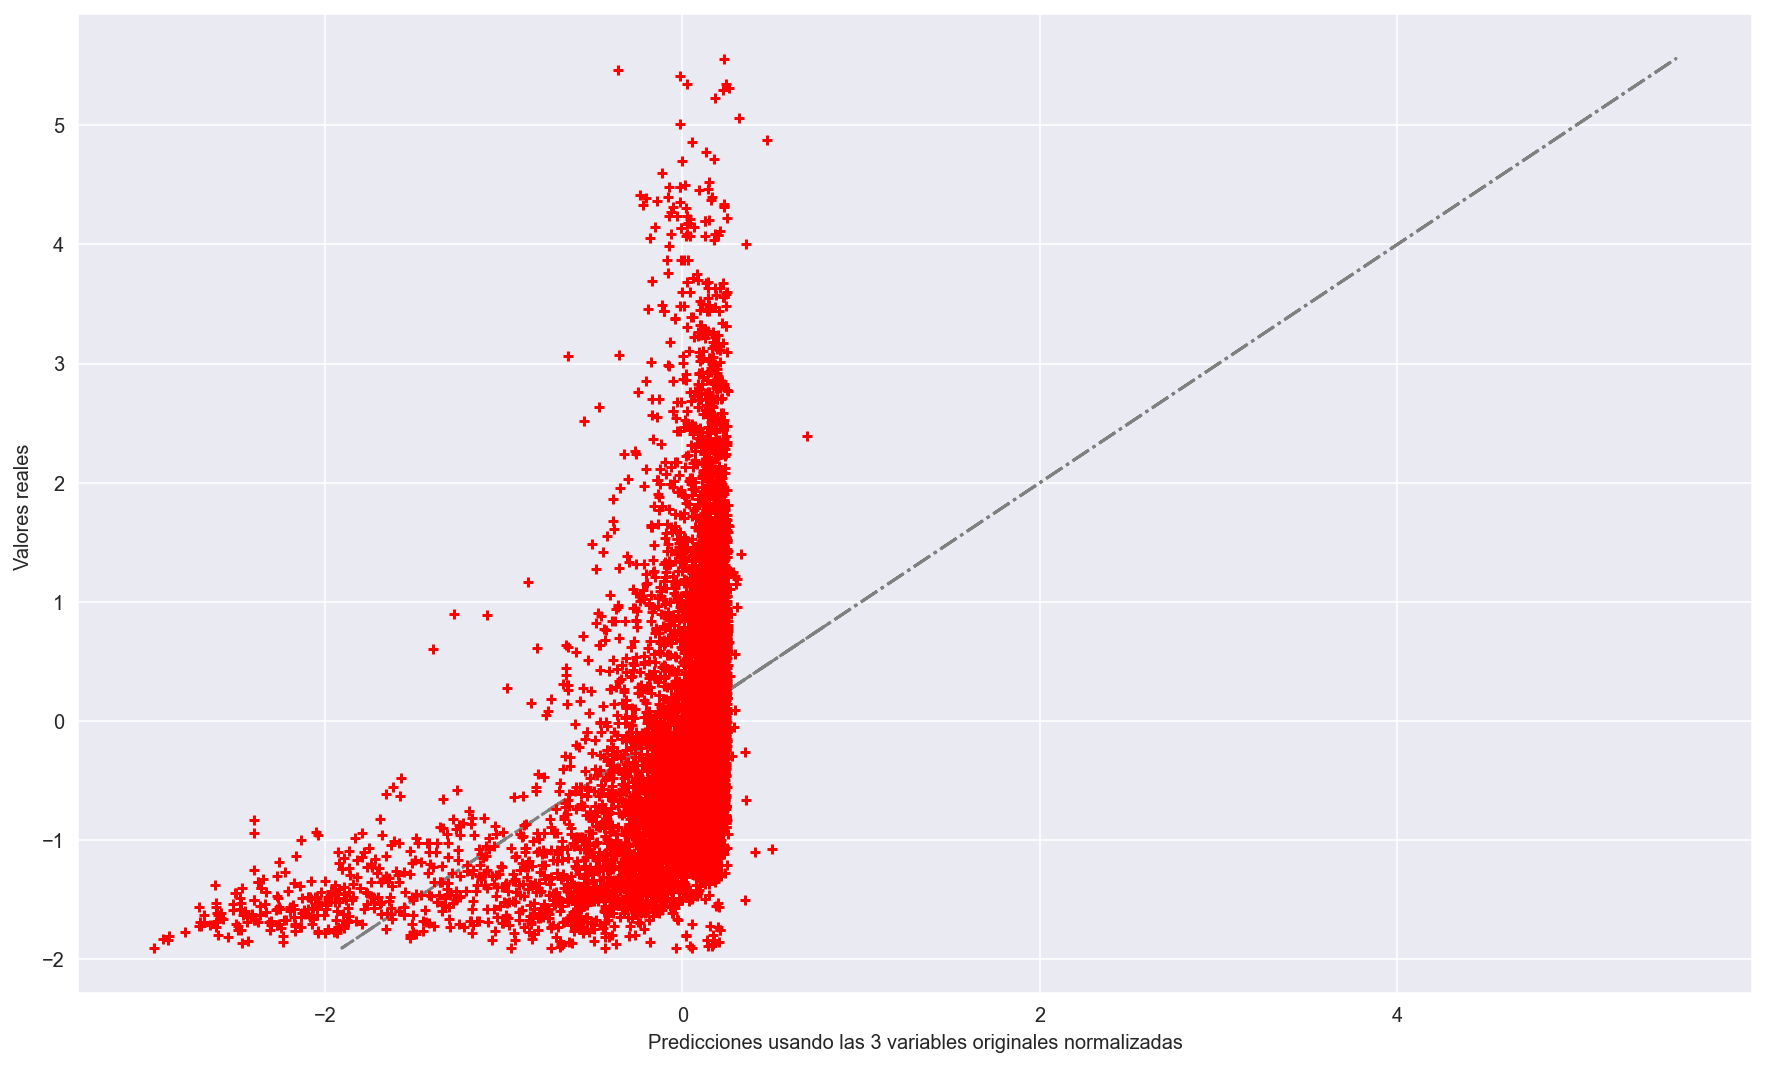

In [116]:
plt.plot(ys_orig_test,ys_orig_test, '-.',c='grey')
plt.scatter(predictionss_orig, ys_orig_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones usando las 3 variables originales normalizadas")
plt.ylabel("Valores reales ")
plt.show()

### Con todos los features sin normalizar

In [69]:
# Hacemos un modelo utilizando todos los features
X_todo = data[data.columns.difference(["price_usd_per_m2"])]
y_todo = data['price_usd_per_m2']

# Separar entre train y test
X_todo_train, X_todo_test, y_todo_train, y_todo_test = train_test_split(X_todo, y_todo)

# Importamos, Instanciamos, Fiteamos, etc..

# Instanciamos el modelo.
lm_todo = LinearRegression()

# Fiteamos el modelo sobre los vectores X e y.
model_todo = lm_todo.fit(X_todo, y_todo)
#
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
predictions_todo = lm_todo.predict(X_todo)

# Imprimimos el intercepto y los coeficientes como atributos del objeto entrenado.
#print ('Intercepto=', ' ', model.intercept_)
#print ('RM=', ' ', model.coef_)
print ('MAE:', metrics.mean_absolute_error(y_todo, predictions_todo))
print ('MSE:', metrics.mean_squared_error(y_todo, predictions_todo))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_todo, predictions_todo)))
print ('R2:', metrics.r2_score(y_todo, predictions_todo))

MAE: 431.3277062742487
MSE: 392026.3323797727
RMSE: 626.1200622722232
R2: 0.6600011697014139


Text(0.5, 0, 'Predicciones usando todas las variables')

Text(0, 0.5, 'Valores reales ')

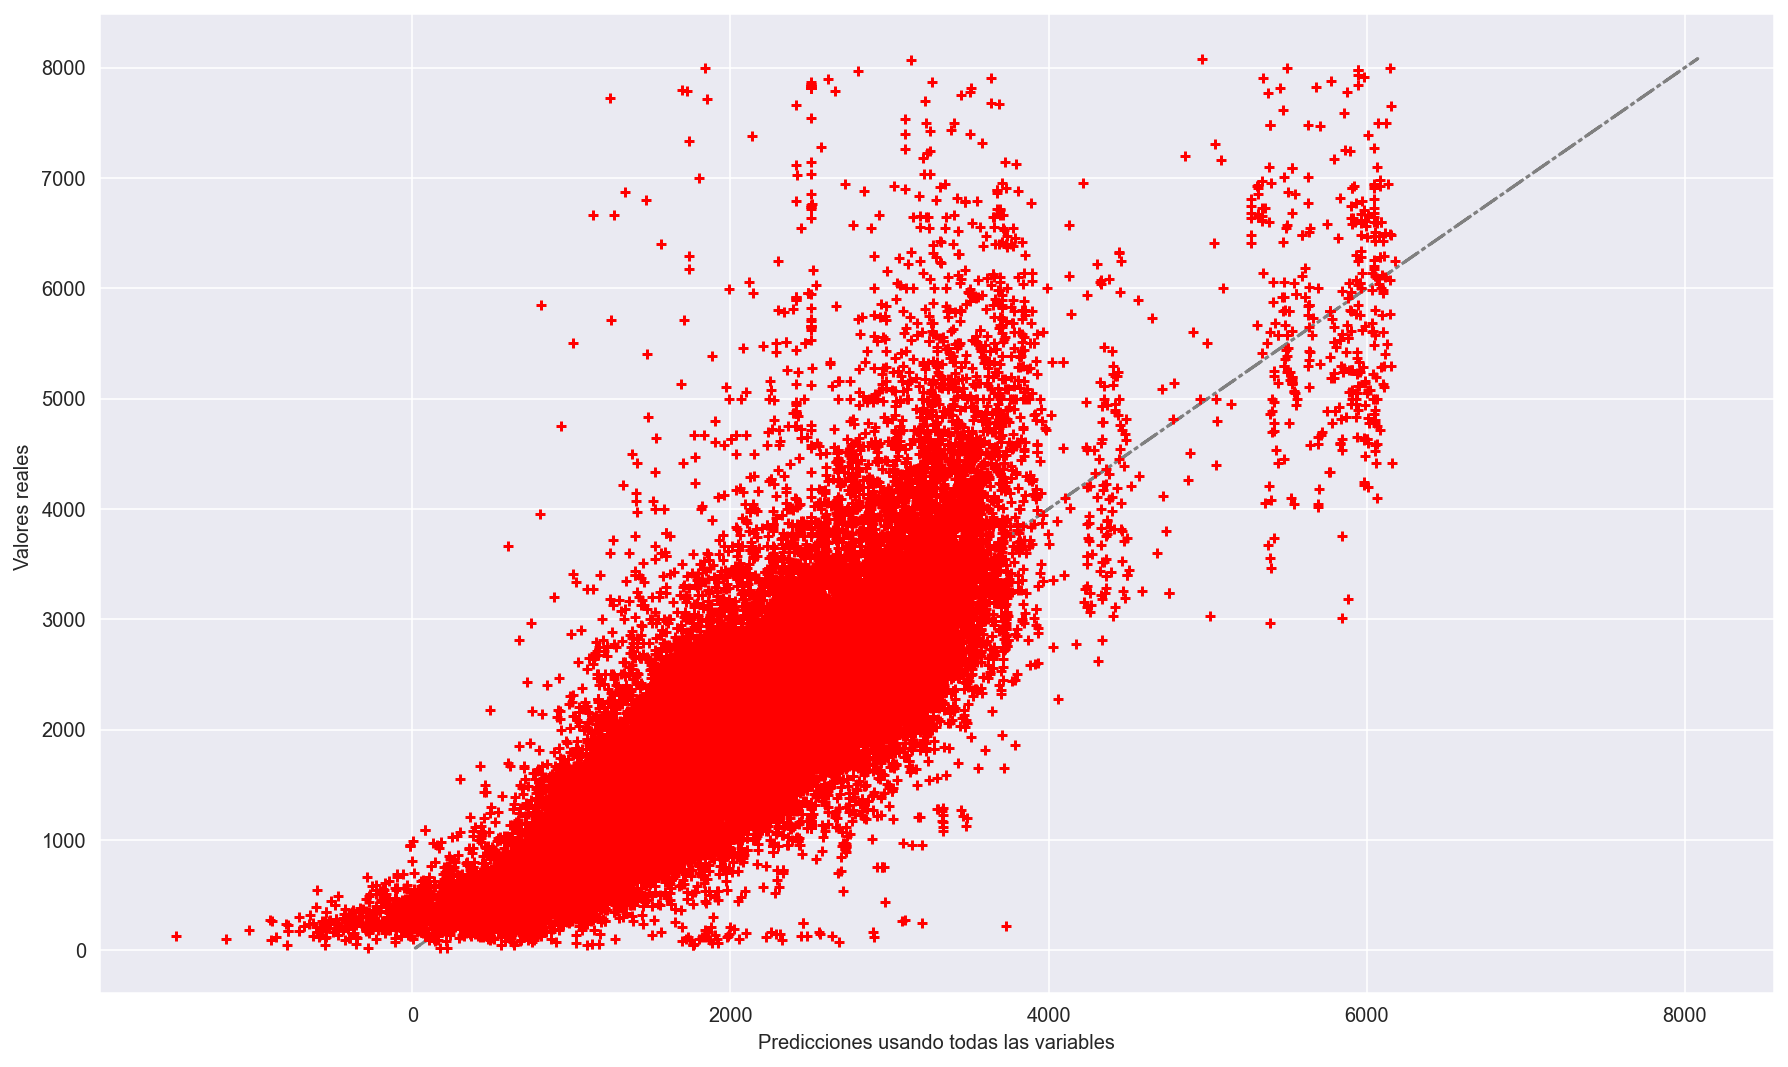

In [70]:
plt.plot(y_todo,y_todo, '-.',c='grey')
plt.scatter(predictions_todo, y_todo, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones usando todas las variables")
plt.ylabel("Valores reales ")
plt.show()

### Con todas las features originales **con normalización**

In [57]:
X_todo = data[data.columns.difference(["price_usd_per_m2"])]
y_todo = data["price_usd_per_m2"]

In [58]:
# Separar entre train y test
X_todo_train, X_todo_test, y_todo_train, y_todo_test = train_test_split(X_todo, y_todo)

# Normalizamos
Xs_todo_train = preprocessing.scale(X_todo_train)
ys_todo_train = preprocessing.scale(y_todo_train)
Xs_todo_test = preprocessing.scale(X_todo_test)
ys_todo_test = preprocessing.scale(y_todo_test)

# Instanciamos el modelo.
lms_todo = LinearRegression()

# Fiteamos el modelo sobre los vectores xs_orig e ys_orig.
models_todo = lms_todo.fit(Xs_todo_train, ys_todo_train)
#
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
predictionss_todo = lms_todo.predict(Xs_todo_test)

# Imprimimos el intercepto y los coeficientes como atributos del objeto entrenado.
print ('Intercepto=', ' ', models_todo.intercept_)
print ('MAE:', metrics.mean_absolute_error(ys_todo_test, predictionss_todo))
print ('MSE:', metrics.mean_squared_error(ys_todo_test, predictionss_todo))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ys_todo_test, predictionss_todo)))
print ('R2:', metrics.r2_score(ys_todo_test, predictionss_todo))

Intercepto=   -1.5819942643642432e-06
MAE: 135903042044.53592
MSE: 4.988740148192553e+24
RMSE: 2233548779004.513
R2: -4.988740148192553e+24


Text(0.5, 0, 'Predicciones usando todas las variables normalizadas')

Text(0, 0.5, 'Valores reales ')

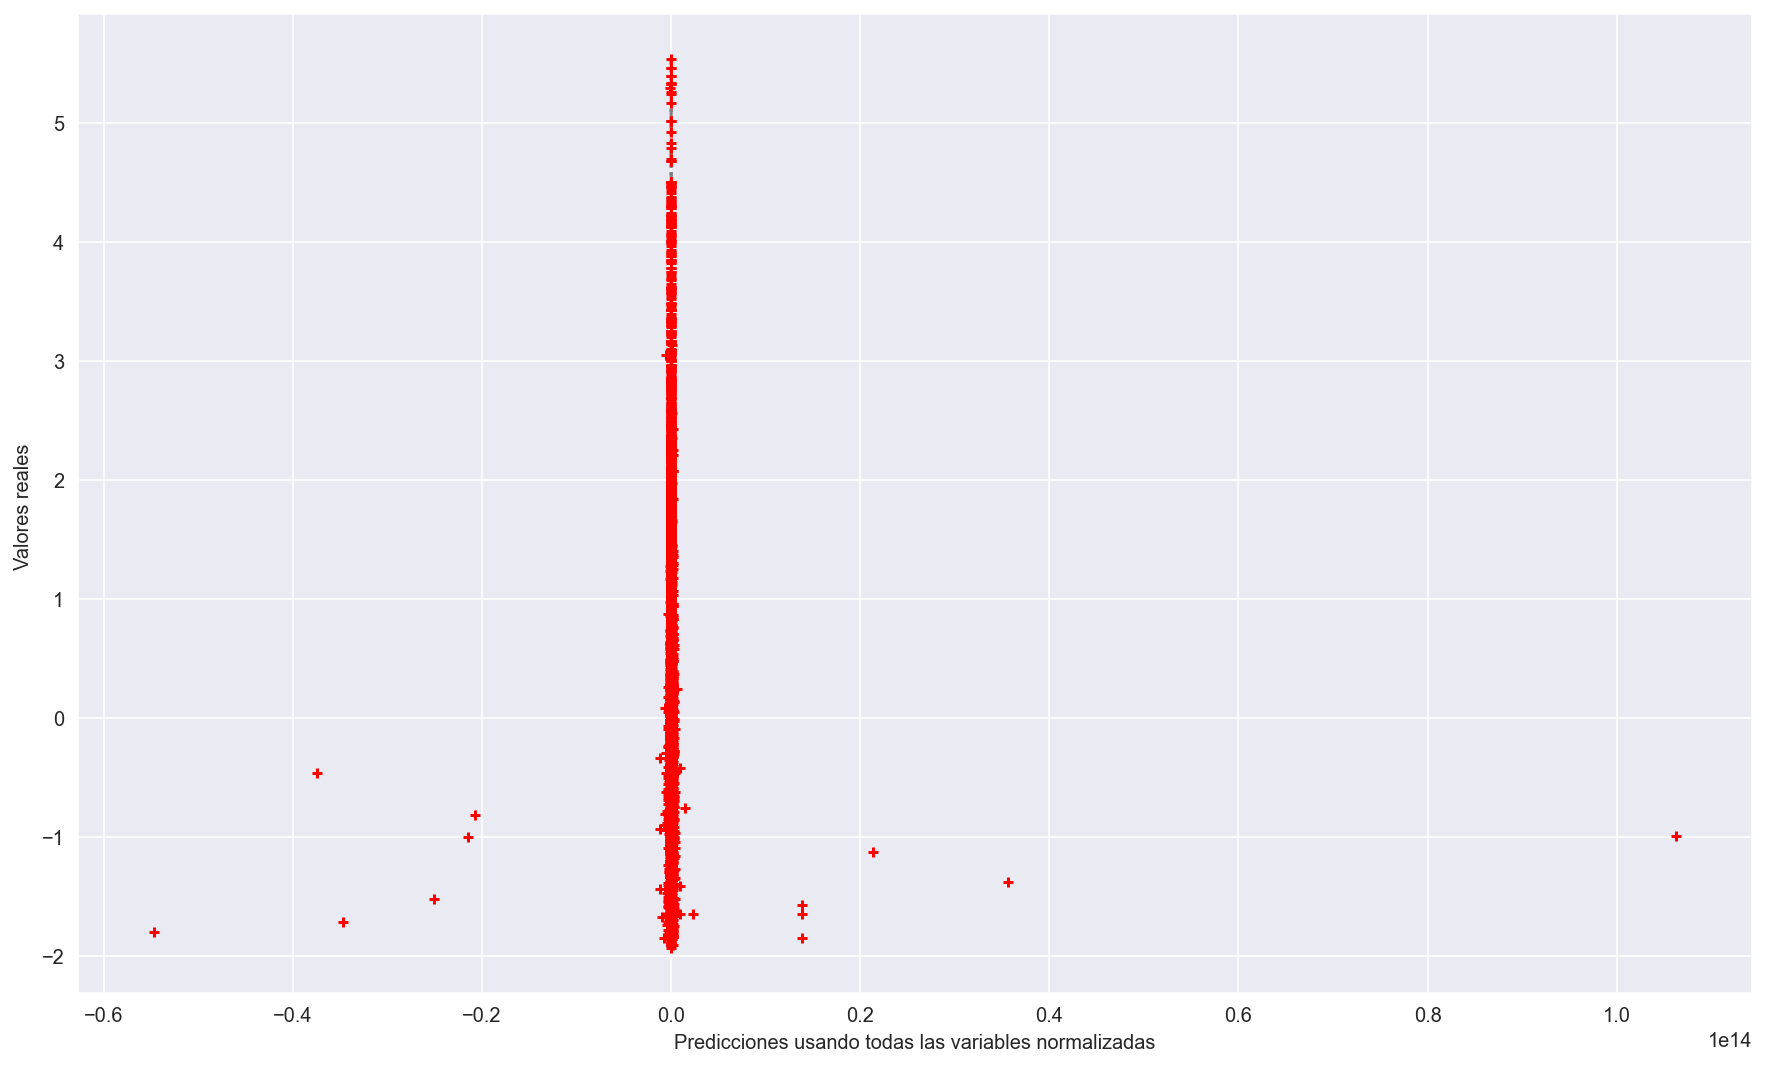

In [109]:
plt.plot(ys_todo_test,ys_todo_test, '-.',c='grey')
plt.scatter(predictionss_todo, ys_todo_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones usando todas las variables normalizadas")
plt.ylabel("Valores reales ")
plt.show()

# **Siguientes pasos R2 ajustado y regularización**


In [75]:
# R2ajustado
n = len(y_train)
p = 5
ypred = model.predict(X_test)
r2 = metrics.r2_score(y_train, ypred)
r2_ajustado = 1 - (1 - r2)*((n-1)/(n - p - 1))

NameError: name 'Xtrain_sklearn' is not defined

## Regularización

### Ridge Regression

In [147]:
X = data[['surface_total_in_m2','surface_covered_in_m2','rooms']]
y = data[['price_usd_per_m2']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Instanciamos el modelo.
lm = LinearRegression()
# Fiteamos el modelo sobre los vectores xs_orig e ys_orig.
model = lm.fit(X_train, y_train)
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
ypred = lm.predict(X_test)

#Modelo Ridge
ridge = linear_model.Ridge(alpha=0.5, normalize=True)
ridge.fit(X_train,y_train)
ypred_ridge = ridge.predict(X_test)

print ('R2:', metrics.r2_score(y_test, ypred))
print ("R2_Ridge:", metrics.r2_score(y_test, ypred_ridge))

Ridge(alpha=0.5, normalize=True)

R2: 0.1734622947875608
R2_Ridge: 0.13961366936203423


In [149]:
# Veamos los coeficientes de la regresión Ridge:    
ridge.coef_

array([[-1.63996167, -0.24479074, -6.05846167]])

### Regression Lasso

In [148]:
X = data[['surface_total_in_m2','surface_covered_in_m2','rooms']]
y = data[['price_usd_per_m2']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Instanciamos el modelo lineal
lm = LinearRegression()
# Fiteamos el modelo sobre los vectores xs_orig e ys_orig.
model = lm.fit(X_train, y_train)
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
ypred = lm.predict(X_test)

#Modelo Lasso
lasso = linear_model.Lasso(alpha=0.5, normalize=True)
lasso.fit(X_train,y_train)
ypred_lasso = lasso.predict(X_test)

print ('R2:', metrics.r2_score(y_test, ypred))
print ("R2_Lasso:", metrics.r2_score(y_test, ypred_lasso))

Lasso(alpha=0.5, normalize=True)

R2: 0.1761361344487128
R2_Lasso: 0.15512649362637165


In [150]:
# Veamos los coeficientes de la regresión Lasso:    
lasso.coef_

array([-2.05064723,  0.        ,  0.        ])

### Elastic Net

In [ ]:
X = data[['surface_total_in_m2','surface_covered_in_m2','rooms']]
y = data[['price_usd_per_m2']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Instanciamos el modelo lineal
lm = LinearRegression()
# Fiteamos el modelo sobre los vectores xs_orig e ys_orig.
model = lm.fit(X_train, y_train)
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
ypred = lm.predict(X_test)

#Modelo elastic Net
elastic_net = linear_model.ElasticNet(alpha=0.5, normalize=True)
elastic_net.fit(X_train, y_train)
ypred_elastic = elastic_net.predict(X_test)

plt.scatter(X_train, y_train)
plt.title("Muestra de datos #1")
plt.scatter(X_train, ypred, c='r')

print ('R2:', metrics.r2_score(y_test, ypred))
print ("R2_Elastic:", metrics.r2_score(y_test, ypred_elastic))

In [ ]:
# Veamos los coeficientes de la regresión ElasticNet:
elastic_net.coef_

### CV Optimizacion de lambda

In [ ]:
# instanciamos un modelo 
rlmcv = linear_model.RidgeCV(alphas=np.linspace(0.1,100, 1000), cv=3, normalize=True,scoring='r2')


# Ajustamos nuevamente nuestro modelo, esta vez con RidgeCV
X = np.vander(xs, 4)[:,:-1]
y = ys
rlmcv.fit(X, y)
predictions = rlmcv.predict(X)

plt.scatter(xs, ys)
plt.title("Muestra de datos #1")
plt.scatter(xs, predictions, c='r')
plt.show()
print ("r^2:", rlmcv.score(X, ys))
print ("alpha:", rlmcv.alpha_)

X = np.vander(xs2, 4)[:,:-1]
predictions = rlmcv.predict(X)

plt.scatter(xs2, ys2)
plt.title("Muestra de datos #2")
plt.scatter(xs2, predictions, c='r')
plt.show()
print ("r^2:", rlmcv.score(X, ys2))

In [ ]:
lassocv = linear_model.LassoCV(alphas=np.linspace(0.01,100, 1000), cv=3, normalize=True)
xs, ys = generate_data()


# Ajustamos nuevamente nuestro modelo, esta vez con LassoCV
X = np.vander(xs, 4)[:,:-1]
y = ys
lassocv.fit(X, y)
predictions = lassocv.predict(X)

plt.scatter(xs, ys)
plt.title("Muestra de datos #1")
plt.scatter(xs, predictions, c='r')
plt.show()
print ("r^2:", lassocv.score(X, ys))
print ("alpha:", lassocv.alpha_)

X = np.vander(xs2, 4)[:,:-1]
predictions = lassocv.predict(X)

plt.scatter(xs2, ys2)
plt.title("Muestra de datos #2")
plt.scatter(xs2, predictions, c='r')
plt.show()
print ("r^2:", lassocv.score(X, ys2))

In [ ]:
# Definimos el rango de de búsqueda del hiperparametro explicitamente
lm_lasso = linear_model.LassoCV(alphas=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                        0.05, 0.1, 1, 5, 10],\
                                        normalize = False, cv = 5) 

model_cv = lm_lasso.fit(X_train, y_train)

model_cv.score(X_train, y_train)

model_cv.coef_
model_cv.intercept_
model_cv.alpha_
model_cv.score(X_train, y_train)

In [ ]:
best_alpha = model_cv.alpha_

#L1_wt : 0, the fit is ridge regression. 1, the fit is the lasso 

no_reg_model = sm.OLS(y_train, X_train_sm)

reg_model = no_reg_model.fit_regularized(alpha = best_alpha, L1_wt = 1)

reg_model.params
sns.scatterplot(x=reg_model.params, y=no_reg_model_params);

reg_residuals = y_train - reg_model.fittedvalues

linear_residuals = y_train - model.fittedvalues

sns.scatterplot(x = reg_residuals, y = linear_residuals)

In [ ]:
sm_prediction = reg_model.predict(X_test_sm)
sm_prediction

In [ ]:
skl_lasso = linear_model.Lasso(alpha = best_alpha, fit_intercept=True, normalize=False)

skl_lasso = skl_lasso.fit(X= X_train, y = y_train)

skl_prediction = skl_lasso.predict(X_test)

In [ ]:
skl_residuals = y_test - skl_prediction

sm_residuals = y_test - sm_prediction

sns.scatterplot(x = skl_residuals, y = sm_residuals)

In [ ]:

lasso_coef = np.insert(skl_lasso.coef_, 0, skl_lasso.intercept_)

sns.scatterplot(x = lasso_coef, y = reg_model.params);


In [ ]:
eval_measures.rmse(y_test, sm_prediction)
eval_measures.meanabs(y_test, sm_prediction)
metrics.r2_score(y_test, sm_prediction)
np.sqrt(metrics.mean_squared_error(y_test, skl_prediction))
metrics.mean_absolute_error(y_test, skl_prediction)
metrics.r2_score(y_test, skl_prediction)

### Ejemplo

In [ ]:
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
  
random.seed(3)
boston = datasets.load_boston()
y = boston.target
X = pd.DataFrame(boston.data, columns=boston.feature_names)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
lr = linear_model.LinearRegression()
cv = KFold(5, shuffle=True)
scores = cross_val_score(lr, X_train, y_train, cv=cv, scoring='r2')
scores, scores.mean()

In [ ]:
model = linear_model.LassoCV().fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum())

In [ ]:
model = linear_model.RidgeCV(normalize=True).fit(X, y)
scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean())

# **Machine Learning**

## Sklearn

In [ ]:
# Definimos parámetros globales para matplotlib.
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 16

In [ ]:
# importamos el modelo lineal y algunas funciones para calcular la bondad de ajuste.
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [ ]:
# Seleccionamos la variable predictora y la objetivo.
X = df[[features]]
y = targets[target]

# Separar entre train y test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

# Importamos, Instanciamos, Fiteamos, etc..

# Instanciamos el modelo.
lm = linear_model.LinearRegression()

# Fiteamos el modelo sobre los vectores X e y.
model = lm.fit(X, y)
#
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
predictions = lm.predict(X)

# Imprimimos el intercepto y los coeficientes como atributos del objeto entrenado.
print ('Intercepto=', ' ', model.intercept_)
print ('RM=', ' ', model.coef_)
# imprimos la metrica que mide la bondad de ajusto del modelo. En este caso el R2.
print ('R2_train=', ' ', model.score(X, y))

In [ ]:
# Generamos una función que resume los coeficientes, el intercepto y el R2
# "model" = objeto con el modelo
# "X" = matrix de variables independientes

def sum_mod(model, X):
    a = pd.DataFrame(model.coef_ , X.columns.values)
    a = a.append(pd.DataFrame([model.intercept_, model.score(X, y)], index=['Intecept','R2']))
    return(a)

In [ ]:
# Graficamos el modelo
plt.plot(y,y, '-.',c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones usando (una, dos, todas) las variables")
plt.ylabel("Valores reales ")
plt.show()
print ("EMC:", mean_squared_error(y, predictions))
print ("¿Mejora?: ", mean_squared_error(y, predictions) < prevMSE)

## Statsmodel

In [ ]:
# Importamos la api.
import statsmodels.api as sm

# De manera análoga a la vista en el primer ejercicio, definimos el vector de variables con la primer variable RM.
X = df[[features]]
y = df[[target]]

# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Graficamos los resultados
plt.plot(y,y, '-.', c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales target")
plt.show()

# Imprimimos el MSE y un resumen del modelo
print ("EMC:", mean_squared_error(y, predictions))
print (model.summary())

In [ ]:
#para CLMultiple
# visualizamos la matriz de correlación en Seaborn usando a heatmap

sns.heatmap(bikes.corr(), vmin=-1, vmax=1, center=0, cmap="YlGnBu");

In [ ]:
#elegir entre modelos
from sklearn import metrics
import numpy as np
print ('MAE:', metrics.mean_absolute_error(true, pred))
print ('MSE:', metrics.mean_squared_error(true, pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))
print ('R2:', metrics.r2_score(true, pred))

In [ ]:
# Definimos una función que acepta una lista de features, hace el split entre train y test,
# reservando un 25% de las observaciones para testeo, y devuelve la prueba RMSE.

from sklearn.model_selection import train_test_split

def train_test_rmse(feature_cols):
    X = bikes[feature_cols]
    y = bikes.total
    # Como estamos trabajando con observaciones ordenadas en el tiempo, ponemos
    # shuffle=False para evitar data leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [ ]:
# Chequeamos que las columnas son perfectamente dependientes.
np.all(bikes.casual + bikes.registered == bikes.total)

## Compruebo los supuestos Gauss Markov

In [ ]:
#linearidad del modelo
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(model, y):
    '''
    funcion para visualizar e identificar supuestos de linealidad sobre la regression lineal
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observados vs. Valores Predichos', fontsize=16)
    ax[0].set(xlabel='Predichos', ylabel='Observados')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residos vs. Valores Predichos', fontsize=16)
    ax[1].set(xlabel='Predichos', ylabel='Residuos')
    
linearity_test(lin_reg, y)  

In [ ]:
#media de los residuos
lin_reg.resid.mean()

In [ ]:
#multicolinearidad uso IVF(inflación de varianza) muestra cuánto más grande es el error estándar, en comparación 
#con lo que sería si ese predictor no estuviera correlacionado con las otras características del modelo . 
#Si no se correlacionan características, todos los valores para VIF serán 1.
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).T

In [ ]:
#homocedasticidad
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    import numpy as np
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')

homoscedasticity_test(lin_reg)

In [ ]:
#autocorrelacion
import statsmodels.tsa.api as smt

acf = smt.graphics.plot_acf(lin_reg.resid, lags=40 , alpha=0.05)
#acf.show();

In [ ]:
#normalidad de los residuos
from scipy import stats

def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')
    
normality_of_residuals_test(lin_reg)

## Variables dummies

In [ ]:
#pandas (drop_first para evitar la colinearidad perfecta)
dummy = pd.get_dummies(df[column], drop_first=True)

In [ ]:
#scikit onehotencoder
from sklearn.preprocessing import OneHotEncoder 
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
# fiteo y transformo la columna "sex"
dummy_oneHot = onehot_encoder.fit_transform(df[['Sex']])
# pongo un vector en un dataset.
dummy_oneHot = pd.DataFrame(dummy_oneHot.toarray(),columns=df['Sex'].unique())
dummy_oneHot.head()

#con drop_first
from sklearn.preprocessing import OneHotEncoder 
onehot_encoder2 = OneHotEncoder(drop='first')
# fiteo y transformo la columna "sex"
dummy_oneHot_correct = onehot_encoder2.fit_transform(df[['Sex']])
# pongo un vector en un dataset.
dummy_oneHot_correct = pd.DataFrame(dummy_oneHot_correct.toarray())
dummy_oneHot_correct.head()

In [ ]:
#para variables categoricas
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(df['Survived'])

## Normalización

In [ ]:
#metodo manual con mean y std
xs = df["NOX"]
ys = df["TAX"]
plt.scatter(xs, ys, color='b')
plt.xlabel("NOX")
plt.ylabel("TAX")
plt.show()

xs = df["NOX"]
mean = np.mean(xs)
std = np.std(xs)
xs = [(x - mean) / std for x in xs]

ys = df["TAX"]
mean = np.mean(ys)
std = np.std(ys)
ys = [(y - mean) / std for y in ys]

plt.scatter(xs, ys, color='r')
plt.xlabel("NOX standardized")
plt.ylabel("TAX standardized")
plt.show()

In [ ]:
from sklearn import preprocessing

xs = preprocessing.scale(df["NOX"])
ys = preprocessing.scale(df["TAX"])

plt.scatter(xs, ys, color='r')
plt.xlabel("NOX standardized")
plt.ylabel("TAX standardized")
plt.show()



In [ ]:
#manual min max
xs = df["NOX"]
ys = df["TAX"]
plt.scatter(xs, ys, color='b')
plt.xlabel("NOX")
plt.ylabel("TAX")
plt.show()

xs = df["NOX"]
xmin = np.min(xs)
xmax = np.max(xs)
xs = [(x - xmin) / (xmax - xmin) for x in xs]

ys = df["TAX"]
ymin = np.min(ys)
ymax = np.max(ys)
ys = [(y - ymin) / (ymax - ymin) for y in ys]

plt.scatter(xs, ys, color='r')
plt.xlabel("NOX Min-Max Scaled")
plt.ylabel("TAX Min-Max Scaled")
plt.show()

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()

xs = scaler.fit_transform(df[["NOX"]])
ys = scaler.fit_transform(df[["TAX"]])

plt.scatter(xs, ys, color='r')
plt.xlabel("NOX Min-Max Scaled")
plt.ylabel("TAX Min-Max Scaled")
plt.show()

#o
numericals = ['carat', 'depth', 'table', 'x', 'y', 'z']

X = data[numericals]

scaler = MinMaxScaler()
scaler.fit(X)

std_numerical_data = scaler.transform(X)
std_df = pd.DataFrame(std_numerical_data)
std_df.columns = [i + '_std' for i in numericals]
std_df


## Regularización

### Ridge Regression

In [ ]:
rlm = linear_model.Ridge(alpha=0.5, normalize=True)

# Ajustamos nuevamente, esta vez con regularizacion
X = np.vander(xs, 4)[:,:-1]
y = ys

ridge_model = rlm.fit(X, y)
predictions = ridge_model.predict(X)

plt.scatter(xs, ys)

plt.title("Muestra de datos #1")
plt.scatter(xs, predictions, c='r')
print ("r^2:", ridge_model.score(X, ys))

In [ ]:
X = np.vander(xs2, 4)[:,:-1]
predictions = ridge_model.predict(X)

plt.scatter(xs2, ys2)
plt.title("Muestra de datos#2")
plt.scatter(xs2, predictions, c='r')

print ("r^2:", ridge_model.score(X, ys2))

In [ ]:
# Veamos los coeficientes de la regresión Ridge:    
ridge_model.coef_

### Regression Lasso

In [ ]:
lasso = linear_model.Lasso(alpha=0.5, normalize=True)

# Ajustamos nuevamente, esta vez con regularizacion
X = np.vander(xs, 4)[:,:-1]
y = ys
lasso_model =lasso.fit(X, y)
predictions = lasso_model.predict(X)

plt.scatter(xs, ys)
plt.title("Muestra de datos #1")
plt.scatter(xs, predictions, c='r')

print ("r^2:", lasso_model.score(X, ys))

In [ ]:
X = np.vander(xs2, 4)[:,:-1]
predictions = lasso_model.predict(X)

plt.scatter(xs2, ys2)
plt.title("Muestra de datos#2")
plt.scatter(xs2, predictions, c='r')

print ("r^2:", lasso_model.score(X, ys2))

In [ ]:
# Veamos los coeficientes de la regresión Lasso:    
lasso_model.coef_

### Elastic Net

In [ ]:
elastic_net = linear_model.ElasticNet(alpha=0.5, normalize=True)

# Ajustamos nuevamente, esta vez con regularizacion
X = np.vander(xs, 4)[:,:-1]
y = ys

elastic_net.fit(X, y)
predictions = elastic_net.predict(X)

plt.scatter(xs, ys)
plt.title("Muestra de datos #1")
plt.scatter(xs, predictions, c='r')

print ("r^2:", elastic_net.score(X, ys))

In [ ]:
X = np.vander(xs2, 4)[:,:-1]
predictions = elastic_net.predict(X)

plt.scatter(xs2, ys2)
plt.title("Muestra de datos#2")
plt.scatter(xs2, predictions, c='r')
print ("r^2:", elastic_net.score(X, ys2))

In [ ]:
# Veamos los coeficientes de la regresión ElasticNet:
elastic_net.coef_

### CV Optimizacion de lambda

In [ ]:
# instanciamos un modelo 
rlmcv = linear_model.RidgeCV(alphas=np.linspace(0.1,100, 1000), cv=3, normalize=True,scoring='r2')


# Ajustamos nuevamente nuestro modelo, esta vez con RidgeCV
X = np.vander(xs, 4)[:,:-1]
y = ys
rlmcv.fit(X, y)
predictions = rlmcv.predict(X)

plt.scatter(xs, ys)
plt.title("Muestra de datos #1")
plt.scatter(xs, predictions, c='r')
plt.show()
print ("r^2:", rlmcv.score(X, ys))
print ("alpha:", rlmcv.alpha_)

X = np.vander(xs2, 4)[:,:-1]
predictions = rlmcv.predict(X)

plt.scatter(xs2, ys2)
plt.title("Muestra de datos #2")
plt.scatter(xs2, predictions, c='r')
plt.show()
print ("r^2:", rlmcv.score(X, ys2))

In [ ]:
lassocv = linear_model.LassoCV(alphas=np.linspace(0.01,100, 1000), cv=3, normalize=True)
xs, ys = generate_data()


# Ajustamos nuevamente nuestro modelo, esta vez con LassoCV
X = np.vander(xs, 4)[:,:-1]
y = ys
lassocv.fit(X, y)
predictions = lassocv.predict(X)

plt.scatter(xs, ys)
plt.title("Muestra de datos #1")
plt.scatter(xs, predictions, c='r')
plt.show()
print ("r^2:", lassocv.score(X, ys))
print ("alpha:", lassocv.alpha_)

X = np.vander(xs2, 4)[:,:-1]
predictions = lassocv.predict(X)

plt.scatter(xs2, ys2)
plt.title("Muestra de datos #2")
plt.scatter(xs2, predictions, c='r')
plt.show()
print ("r^2:", lassocv.score(X, ys2))

In [ ]:
# Definimos el rango de de búsqueda del hiperparametro explicitamente
lm_lasso = linear_model.LassoCV(alphas=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                        0.05, 0.1, 1, 5, 10],\
                                        normalize = False, cv = 5) 

model_cv = lm_lasso.fit(X_train, y_train)

model_cv.score(X_train, y_train)

model_cv.coef_
model_cv.intercept_
model_cv.alpha_
model_cv.score(X_train, y_train)

In [ ]:
best_alpha = model_cv.alpha_

#L1_wt : 0, the fit is ridge regression. 1, the fit is the lasso 

no_reg_model = sm.OLS(y_train, X_train_sm)

reg_model = no_reg_model.fit_regularized(alpha = best_alpha, L1_wt = 1)

reg_model.params
sns.scatterplot(x=reg_model.params, y=no_reg_model_params);

reg_residuals = y_train - reg_model.fittedvalues

linear_residuals = y_train - model.fittedvalues

sns.scatterplot(x = reg_residuals, y = linear_residuals)

In [ ]:
sm_prediction = reg_model.predict(X_test_sm)
sm_prediction

In [ ]:
skl_lasso = linear_model.Lasso(alpha = best_alpha, fit_intercept=True, normalize=False)

skl_lasso = skl_lasso.fit(X= X_train, y = y_train)

skl_prediction = skl_lasso.predict(X_test)

In [ ]:
skl_residuals = y_test - skl_prediction

sm_residuals = y_test - sm_prediction

sns.scatterplot(x = skl_residuals, y = sm_residuals)

In [ ]:

lasso_coef = np.insert(skl_lasso.coef_, 0, skl_lasso.intercept_)

sns.scatterplot(x = lasso_coef, y = reg_model.params);


In [ ]:
eval_measures.rmse(y_test, sm_prediction)
eval_measures.meanabs(y_test, sm_prediction)
metrics.r2_score(y_test, sm_prediction)
np.sqrt(metrics.mean_squared_error(y_test, skl_prediction))
metrics.mean_absolute_error(y_test, skl_prediction)
metrics.r2_score(y_test, skl_prediction)

### Ejemplo

In [ ]:
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
  
random.seed(3)
boston = datasets.load_boston()
y = boston.target
X = pd.DataFrame(boston.data, columns=boston.feature_names)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
lr = linear_model.LinearRegression()
cv = KFold(5, shuffle=True)
scores = cross_val_score(lr, X_train, y_train, cv=cv, scoring='r2')
scores, scores.mean()

In [ ]:
model = linear_model.LassoCV().fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum())

In [ ]:
model = linear_model.LassoCV(normalize=True).fit(X, y)
scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum())

In [ ]:
model = linear_model.RidgeCV(normalize=True).fit(X, y)
scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean())

### Ejemplo 2

In [ ]:
# Importamos las librerías

%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('../Data/salary.dat', delim_whitespace=True)

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
# Aplicar value_counts() a las series "sx", "dg", and "rk"

categories = ['sx', 'rk', 'dg']

for category in categories:
    print(df[category].value_counts())
    plt.bar(df[category].value_counts().index, df[category].value_counts().values, color='b',\
            alpha=0.5)
    plt.show()

In [ ]:
# Hacer unos violinplots a las series "sx", "dg", and "rk"

for category in categories:
    sns.violinplot(x=category, y='sl', data=df)
    plt.show()

# Repetir para "dg" y "rk"

In [ ]:
# Crear variables "dummy"

for category in categories:
    serie = df[category]
    dummies = pd.get_dummies(serie, drop_first= True, prefix=category)
    df = pd.concat([df, dummies], axis=1)

df.head()

In [ ]:
# Ajustamos el modelo usando solamente las variables cuantitativas y MCO

X = df[['yr', 'yd']]
y = df['sl']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=10)

lm = linear_model.LinearRegression()

model_1 = lm.fit(X_train, y_train)

print('Score model_1:', model_1.score(X_test, y_test))

In [ ]:
# Ajustamos el modelo usando solamente las variables cuantitativas aplicando regularización
#¿Hace falta normalizar los features antes aplicar regularización en este caso? ¿Qué unidades tienen los features?

lm_ridge = linear_model.RidgeCV(alphas=[0.1, 1, 10], normalize=True) 
# Definimos el rango de de búsqueda del hiperparametro explicitamente

model_2 = lm_ridge.fit(X_train, y_train)

print('Score model_2:', model_2.score(X_test, y_test))

# ¿Mejoraron los resultados?

In [ ]:
# Ahora entrenamos el modelo con todas las variables con MCO:

X_all = df.drop(['sx', 'rk', 'dg', 'sl'], axis=1) 

X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y, test_size=0.35, random_state=10)

model_3 = lm.fit(X_all_train, y_all_train)

print('Score model_3:', model_3.score(X_all_test, y_all_test))

In [ ]:
# Ahora entrenamos el modelo con todas las variables con Ridge:

lm_ridge = linear_model.RidgeCV(alphas=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                        0.05, 0.1, 1, 5, 10],\
                                        normalize=True, cv=3) 
# Definimos el rango de de búsqueda del hiperparametro explicitamente

model_4 = lm_ridge.fit(X_all_train, y_all_train)

print('Score model_4:', model_4.score(X_all_test, y_all_test))

# ¿Mejoraron los resultados?

In [ ]:
lm_ridge.alpha_

In [ ]:
# Ahora entrenamos el modelo con todas las variables con Lasso:

lm_lasso = linear_model.LassoCV(alphas=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                        0.05, 0.1, 1, 5, 10, 15, 25],\
                                        normalize=True, cv=3)

model_5 = lm_lasso.fit(X_all_train, y_all_train)

print('Score model_5:', model_5.score(X_all_test, y_all_test))

In [ ]:
lm_lasso.alpha_

# De articulo Comparacion Rendimiento

In [ ]:
'''
LINEAR, RIDGE AND LASSO REGRESSION
'''
# importing requuired libraries
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge

# read test and train file
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('\n\n---------DATA---------------\n\n')
print(train.head())

#splitting into training and test
## try building model with the different features and compare the result.
X = train.loc[:,['Outlet_Establishment_Year','Item_MRP']]
x_train, x_cv, y_train, y_cv = train_test_split(X,train.Item_Outlet_Sales,random_state=5)

print('--------Trainig Linear Regression Model---------------')
lreg = LinearRegression()
#training the model
lreg.fit(x_train,y_train)

#predicting on cv
pred = lreg.predict(x_cv)

#calculating mse
mse = np.mean((pred - y_cv)**2)
print('\nMean Sqaured Error = ',mse )

#Let us take a look at the coefficients of this linear regression model.
# calculating coefficients
coeff = DataFrame(x_train.columns)

coeff['Coefficient Estimate'] = Series(lreg.coef_)

print(coeff)

print('\n\nModel performance on Test data = ')
print(lreg.score(x_cv,y_cv))

print('\n\n---------Training Ridge Regression Model----------------')

ridge = Ridge()
ridge.fit(x_train,y_train)
pred1 = ridge.predict(x_cv)
mse_1 = np.mean((pred1-y_cv)**2)

print('\n\nMean Squared Error = ',mse_1)

# calculating coefficients
coeff = DataFrame(x_train.columns)
coeff['Coefficient Estimate'] = Series(ridge.coef_)
print(coeff)

print('\n\nModel performance on Test data = ')
print(ridge.score(x_cv,y_cv))


print('\n\n---------Training Lasso Regression Model----------------')

lasso = Lasso()
lasso.fit(x_train,y_train)
pred2 = lasso.predict(x_cv)
mse_2 = np.mean((pred2-y_cv)**2)

print('\n\nMean Squared Error = ',mse_2)

# calculating coefficients
coeff = DataFrame(x_train.columns)
coeff['Coefficient Estimate'] = Series(lasso.coef_)
print(coeff)

print('\n\nModel performance on Test data = ')
print(lasso.score(x_cv,y_cv))